# TODO

Data to store:

A. Timed trajectory in name of file along with the positions and data

B. Forces of each drone with timed trajectory in name of file

C. Betas of each dron with position and timed trajectory name of file 

D. Timed trajectory - under topic name "trajectory"

E. CHECK HOW TIME IS STORED AND SEND FROM DYNAMICAL MODEL BETTER

F. STAY IN POINT UNTIL REACH

Plots: 

A. Position leader in comparison to trajectory - DONE

B. Distances between quadcopters - collisions - DONE

C. Distances between quadcopters - connectivity - DONE

D. Forces and betas for all quadcopters

E. Position evolution of all quadcopters


# Prepare data - NOT NECESSARY WHEN TRAJECTORY STORAGE IS ADDED

In [144]:
#for filename in glob.glob('*.npy'):
#    npyData = np.load(filename).item()
#    if not "trajectory" in npyData:
#        npyData["trajectory"] = {}
#        npyData["trajectory"]["pos"] = [[0, 0, 0.2],[0, 0, 2], [0, 0, 5], [4, 5, 3],[-2, 4, 2],[3, -2, 3],[1, -1, 2], [0, 0, 0]]
#        npyData["trajectory"]["time"] = [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0]
#    np.save("./modified_data", npyData)


# Unpack data

In [145]:
import glob
import numpy as np

data = {}
for filename in glob.glob('*.npy'):
    data[filename.split(".")[0].split("_")[-2]] = np.load(filename, encoding = "latin1").item()
    data[filename.split(".")[0].split("_")[-2]]["trajectoryType"] = filename.split(".")[0].split("_")[-1]


# Get position leader

In [146]:
position_leader = {}
trajectory_data = {}
for key in data.keys():
    position_leader[key] = {}
    position_leader[key]["pos"] = data[key]["crazyflie_0"]["pos"]
    position_leader[key]["time"] = sorted(data[key]["crazyflie_0"]["time"])
    trajectory_data[key] = {}
    trajectory_data[key]["pos"] = np.array(data[key]["trajectory"]["pos"])
    trajectory_data[key]["time"] = sorted(data[key]["trajectory"]["time"])

# Create subplots and individual plots

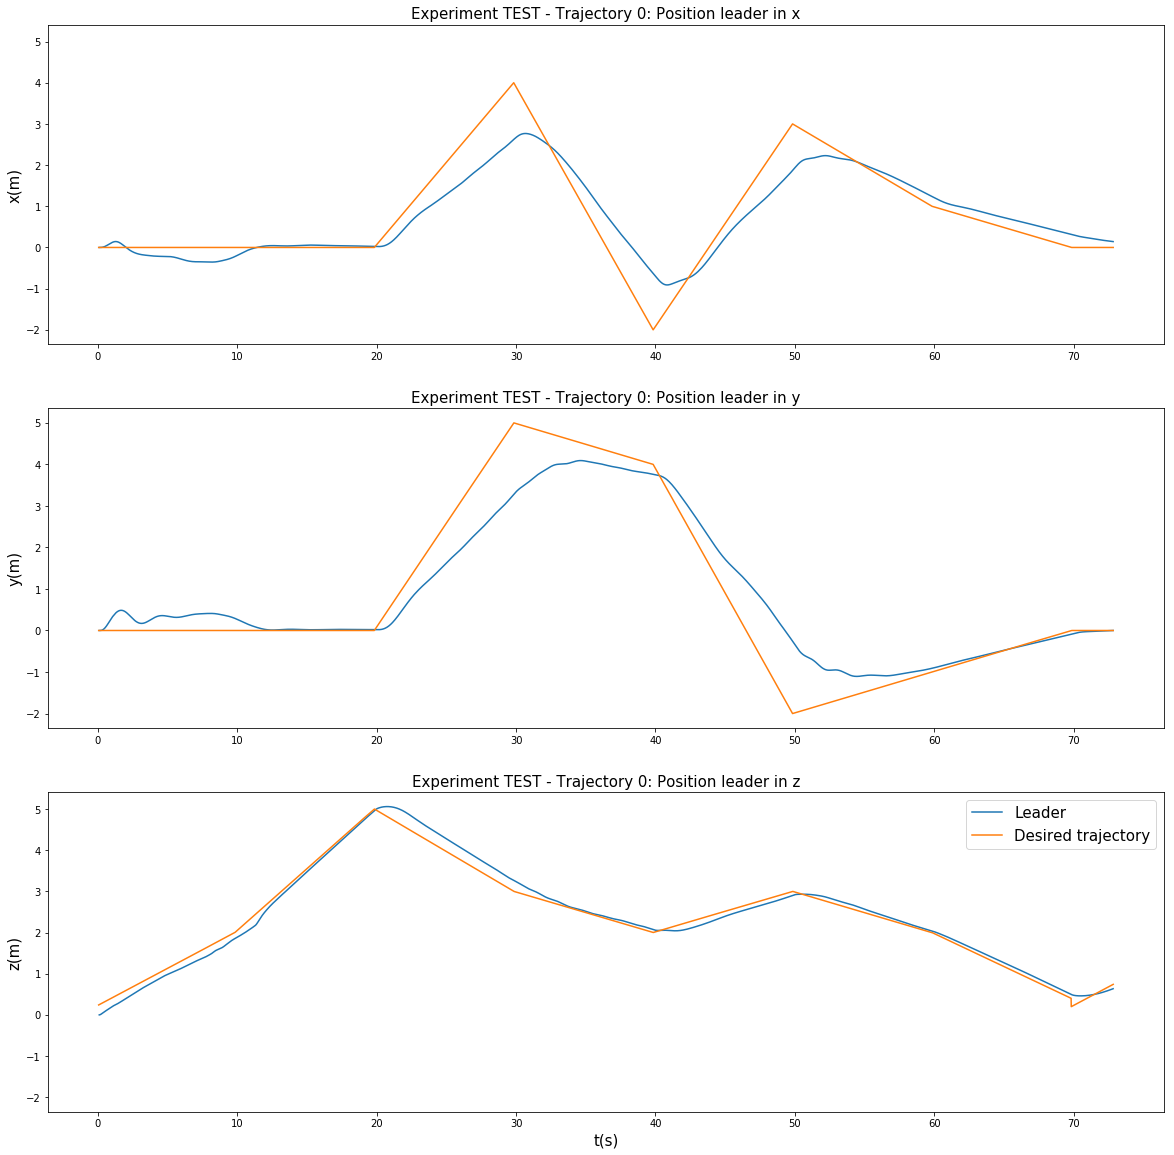

In [147]:
import matplotlib.pyplot as plt

for key in data.keys():
    fig = plt.figure(figsize=(20, 20))
    
    ax1 = plt.subplot(311)

    plt.plot(position_leader[key]["time"], position_leader[key]["pos"][:, 0], label = "Leader")
    plt.plot(trajectory_data[key]["time"], trajectory_data[key]["pos"][:, 0], label = "Desired trajectory")
    
    plt.title("Experiment " + key + " - Trajectory " + data[key]["trajectoryType"] + ": Position leader in x", fontsize=15)
    plt.ylabel("x(m)", fontsize=15)
    plt.setp(ax1.get_xticklabels(), fontsize=10)

    # share x only
    ax2 = plt.subplot(312, sharex=ax1)
    plt.plot(position_leader[key]["time"], position_leader[key]["pos"][:, 1], label = "Leader")
    plt.plot(trajectory_data[key]["time"], trajectory_data[key]["pos"][:, 1], label = "Desired trajectory")
    
    plt.title("Experiment " + key + " - Trajectory " + data[key]["trajectoryType"] + ": Position leader in y", fontsize=15)
    plt.ylabel("y(m)", fontsize=15)
    plt.setp(ax1.get_xticklabels(), fontsize=10)

    # share x and y
    ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
    plt.plot(position_leader[key]["time"], position_leader[key]["pos"][:, 2], label = "Leader")
    plt.plot(trajectory_data[key]["time"], trajectory_data[key]["pos"][:, 2], label = "Desired trajectory")
    
    plt.title("Experiment " + key + " - Trajectory " + data[key]["trajectoryType"] + ": Position leader in z", fontsize=15)
    plt.ylabel("z(m)", fontsize=15)   
    plt.xlabel("t(s)", fontsize=15)   
    plt.setp(ax1.get_xticklabels(), fontsize=10)
    plt.legend(fontsize=15)
    plt.savefig("./images/leader_2D_experiment_" + key + ".png", bbox_inches='tight')
    plt.savefig("./images/leader_2D_experiment_" + key + ".eps", bbox_inches='tight')
    plt.show()

# 3D leader trajectory

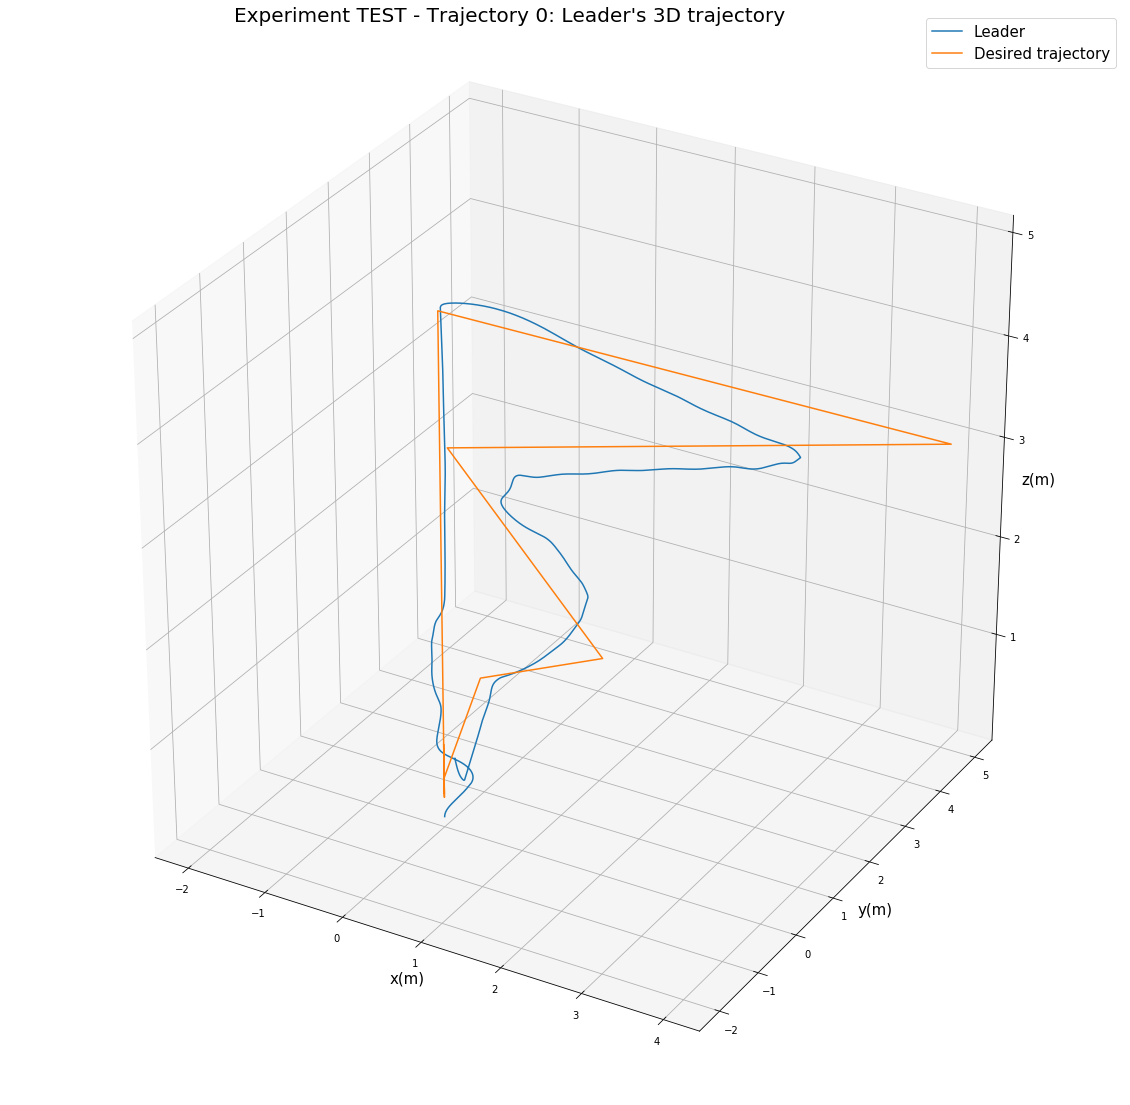

In [148]:
from mpl_toolkits.mplot3d import Axes3D

for key in data.keys():
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111, projection='3d')
    
    plt.plot(position_leader[key]["pos"][:, 0], position_leader[key]["pos"][:, 1], position_leader[key]["pos"][:, 2], label = "Leader")   
    plt.plot(trajectory_data[key]["pos"][:, 0], trajectory_data[key]["pos"][:, 1], trajectory_data[key]["pos"][:, 2], label = "Desired trajectory")
    ax.set_xlabel("x(m)", fontsize=15)   
    ax.set_ylabel("y(m)", fontsize=15)   
    ax.set_zlabel("z(m)", fontsize=15)   
    plt.title("Experiment " + key + " - Trajectory " + data[key]["trajectoryType"] + ": Leader's 3D trajectory", fontsize = 20, x = 0.45, y = 1.07)
    plt.legend(fontsize=15)
    plt.savefig("./images/leader_3D_experiment_" + key + ".png", bbox_inches='tight')
    plt.savefig("./images/leader_3D_experiment_" + key + ".eps", bbox_inches='tight')
    plt.show()

# Interpolation

In [149]:
from scipy.interpolate import interp1d

for experiment in data.keys():
    maxTime = 1e20
    minTime = -1e20
    for key in data[experiment].keys():
        if key.split("_")[0] == "crazyflie":
            data[experiment][key]["interpolation"] = {}
            data[experiment][key]["interpolation"]["x"] = interp1d(data[experiment][key]["time"], data[experiment][key]["pos"][:, 0], kind='cubic')
            data[experiment][key]["interpolation"]["y"] = interp1d(data[experiment][key]["time"], data[experiment][key]["pos"][:, 1], kind='cubic')
            data[experiment][key]["interpolation"]["z"] = interp1d(data[experiment][key]["time"], data[experiment][key]["pos"][:, 2], kind='cubic')
            maxTime = min(maxTime, max(data[experiment][key]["time"]))   
            minTime = max(minTime, min(data[experiment][key]["time"]))
    data[experiment]["distanceTime"] = np.arange(minTime, maxTime, 0.01)

# Collision distances

In [150]:
for experiment in data.keys():
    counter = 0
    experimentTime = data[experiment]["distanceTime"]
    for ids in data[experiment].keys():
        if ids.split("_")[0] == 'crazyflie':
            counter = counter + 1
    for i in np.arange(counter):
        for j in np.arange(i + 1, counter):
            data[experiment]["distanceCol_" + str(i) + "_" + str(j)] = np.sqrt((data[experiment]["crazyflie_" + str(i)]["interpolation"]["x"](experimentTime) - data[experiment]["crazyflie_" + str(j)]["interpolation"]["x"](experimentTime))**2 +  
                                                                              (data[experiment]["crazyflie_" + str(i)]["interpolation"]["y"](experimentTime) - data[experiment]["crazyflie_" + str(j)]["interpolation"]["y"](experimentTime))**2 +
                                                                             (data[experiment]["crazyflie_" + str(i)]["interpolation"]["z"](experimentTime) - data[experiment]["crazyflie_" + str(j)]["interpolation"]["z"](experimentTime))**2)

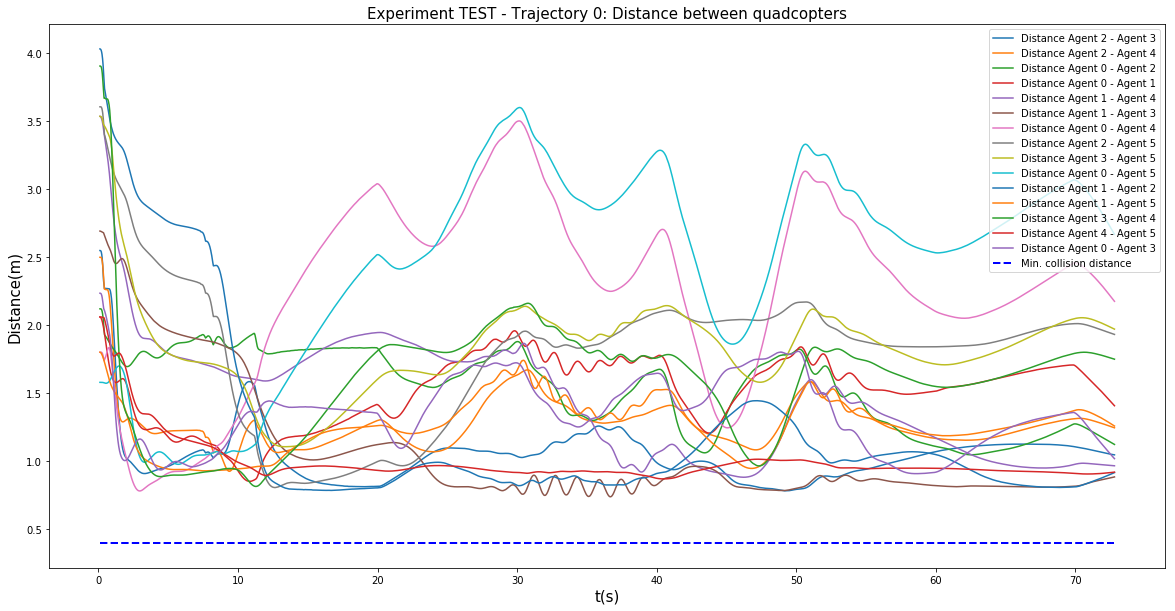

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = plt.subplot(111)
    
    for key in data[experiment].keys():
        if key.split("_")[0] == 'distanceCol':
            i = key.split("_")[1]
            j = key.split("_")[2]

            plt.plot( data[experiment]["distanceTime"], data[experiment][key], label = "Distance Agent " + str(i) + " - Agent " + str(j))
            
    plt.plot( [data[experiment]["distanceTime"][0], data[experiment]["distanceTime"][-1]],[0.4, 0.4], color='blue', linestyle='dashed', linewidth=2, label = "Min. collision distance")
    plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
    plt.ylabel("Distance(m)", fontsize=15)   
    plt.xlabel("t(s)", fontsize=15)   
    plt.setp(ax1.get_xticklabels(), fontsize=10)
    plt.legend(fontsize=10)
    plt.savefig("./images/distances_experiment_" + experiment + ".png", bbox_inches='tight')
    plt.savefig("./images/distances_experiment_" + experiment + ".eps", bbox_inches='tight')
    plt.show()

   

# Connection distances

In [ ]:
dictionary_of_trajectory = {"TEST": {0 : [1, 2, 3], 1 : [5], 2 : [3, 4], 4: [5] }}

for experiment in data.keys():
    for key in dictionary_of_trajectory[experiment].keys():
        for index in dictionary_of_trajectory[experiment][key]:
            data[experiment]["distanceCon_" + str(key) + "_" + str(index)] = np.sqrt((data[experiment]["crazyflie_" + str(key)]["interpolation"]["x"](experimentTime) - data[experiment]["crazyflie_" + str(index)]["interpolation"]["x"](experimentTime))**2 +  
                                                                              (data[experiment]["crazyflie_" + str(key)]["interpolation"]["y"](experimentTime) - data[experiment]["crazyflie_" + str(index)]["interpolation"]["y"](experimentTime))**2 +
                                                                             (data[experiment]["crazyflie_" + str(key)]["interpolation"]["z"](experimentTime) - data[experiment]["crazyflie_" + str(index)]["interpolation"]["z"](experimentTime))**2)

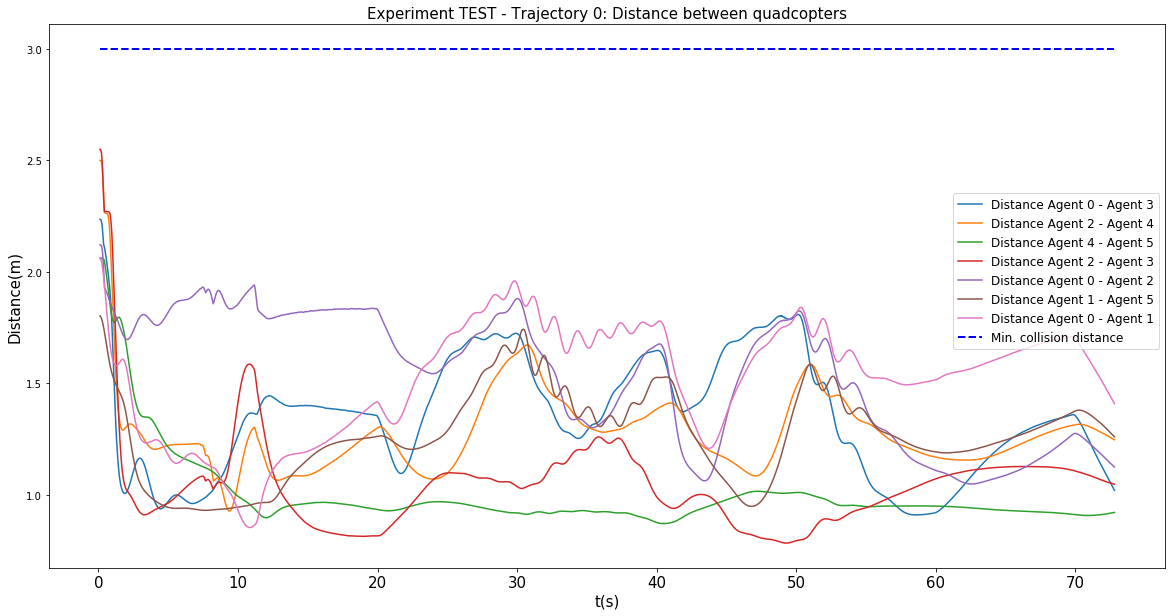

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = plt.subplot(111)
    
    for key in data[experiment].keys():
        if key.split("_")[0] == 'distanceCon':
            i = key.split("_")[1]
            j = key.split("_")[2]

            plt.plot( data[experiment]["distanceTime"], data[experiment][key], label = "Distance Agent " + str(i) + " - Agent " + str(j))
            
    plt.plot( [data[experiment]["distanceTime"][0], data[experiment]["distanceTime"][-1]],[3, 3], color='blue', linestyle='dashed', linewidth=2, label = "Min. collision distance")
    plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
    plt.ylabel("Distance(m)", fontsize=15)   
    plt.xlabel("t(s)", fontsize=15)   
    plt.setp(ax1.get_xticklabels(), fontsize=15)
    plt.legend(fontsize=12, loc='best', bbox_to_anchor=(0.5, 0.2, 0.5, 0.5))
    plt.savefig("./images/distances_experiment_" + experiment + ".png", bbox_inches='tight')
    plt.savefig("./images/distances_experiment_" + experiment + ".eps", bbox_inches='tight')
    plt.show()


# Input and betas

In [ ]:
forcesBetas = {}
for experiment in data.keys(): 
    forcesBetas[experiment] = {}
    for key in data[experiment].keys():
        if key.split("_")[0] == "crazyflie":
            forcesBetas[experiment][key] = {}
for experiment in data.keys(): 
    for key in data[experiment].keys():
        if key.split("_")[0] == "betas":
            forcesBetas[experiment]["crazyflie_" + key.split("_")[2]]["beta_con"] = data[experiment][key]["beta_con"]
            forcesBetas[experiment]["crazyflie_" + key.split("_")[2]]["beta_col"] = data[experiment][key]["beta_col"]
        if key.split("_")[0] == "forces":
            forcesBetas[experiment]["crazyflie_" + key.split("_")[2]]["force"] = data[experiment][key]["force"]

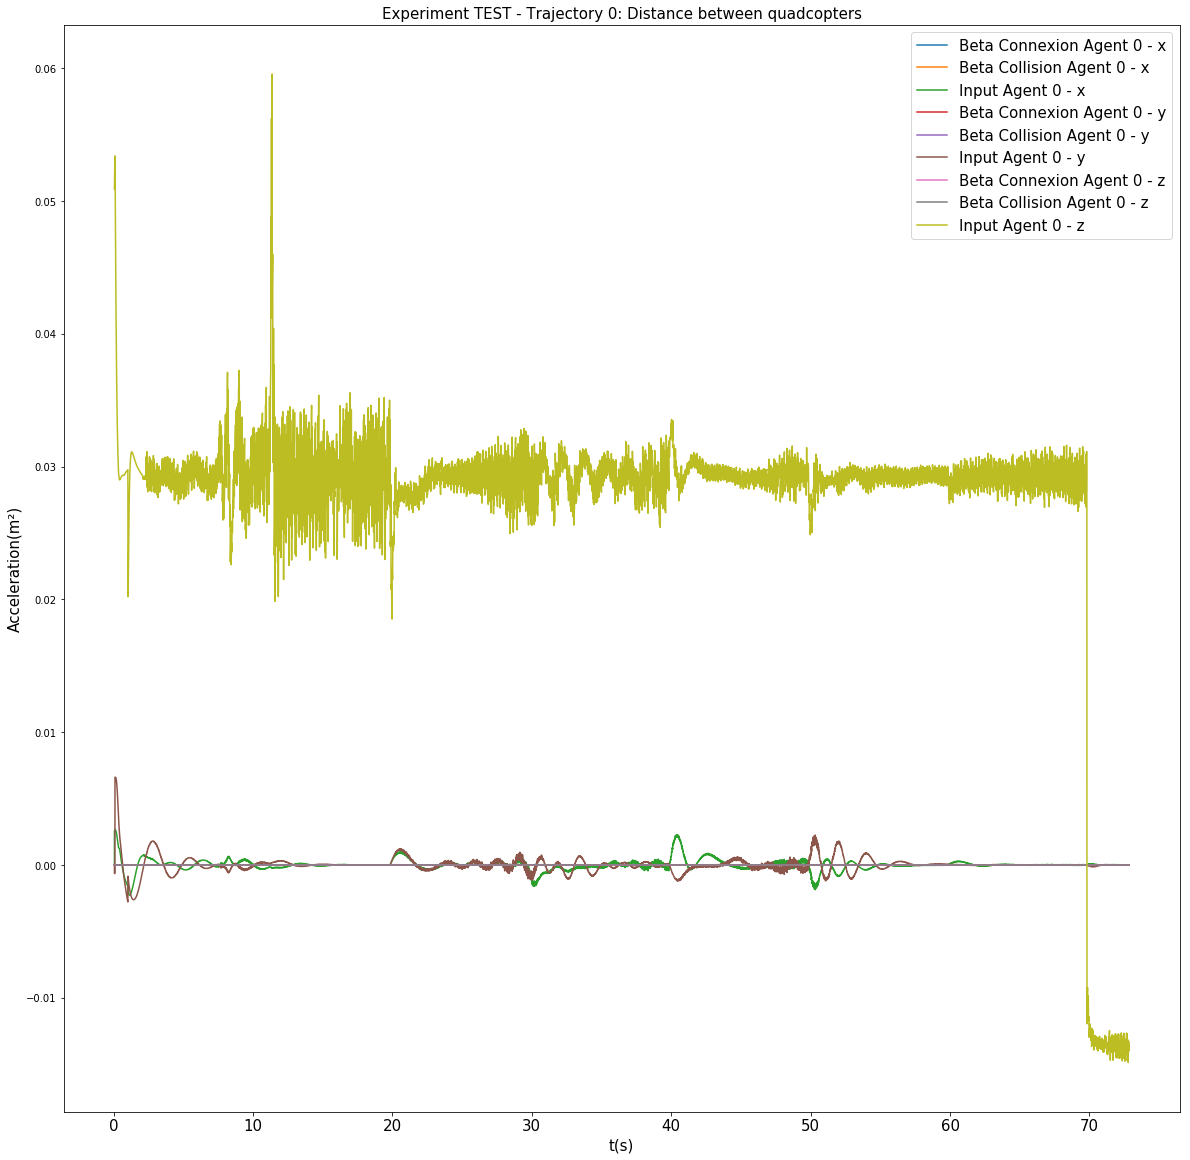

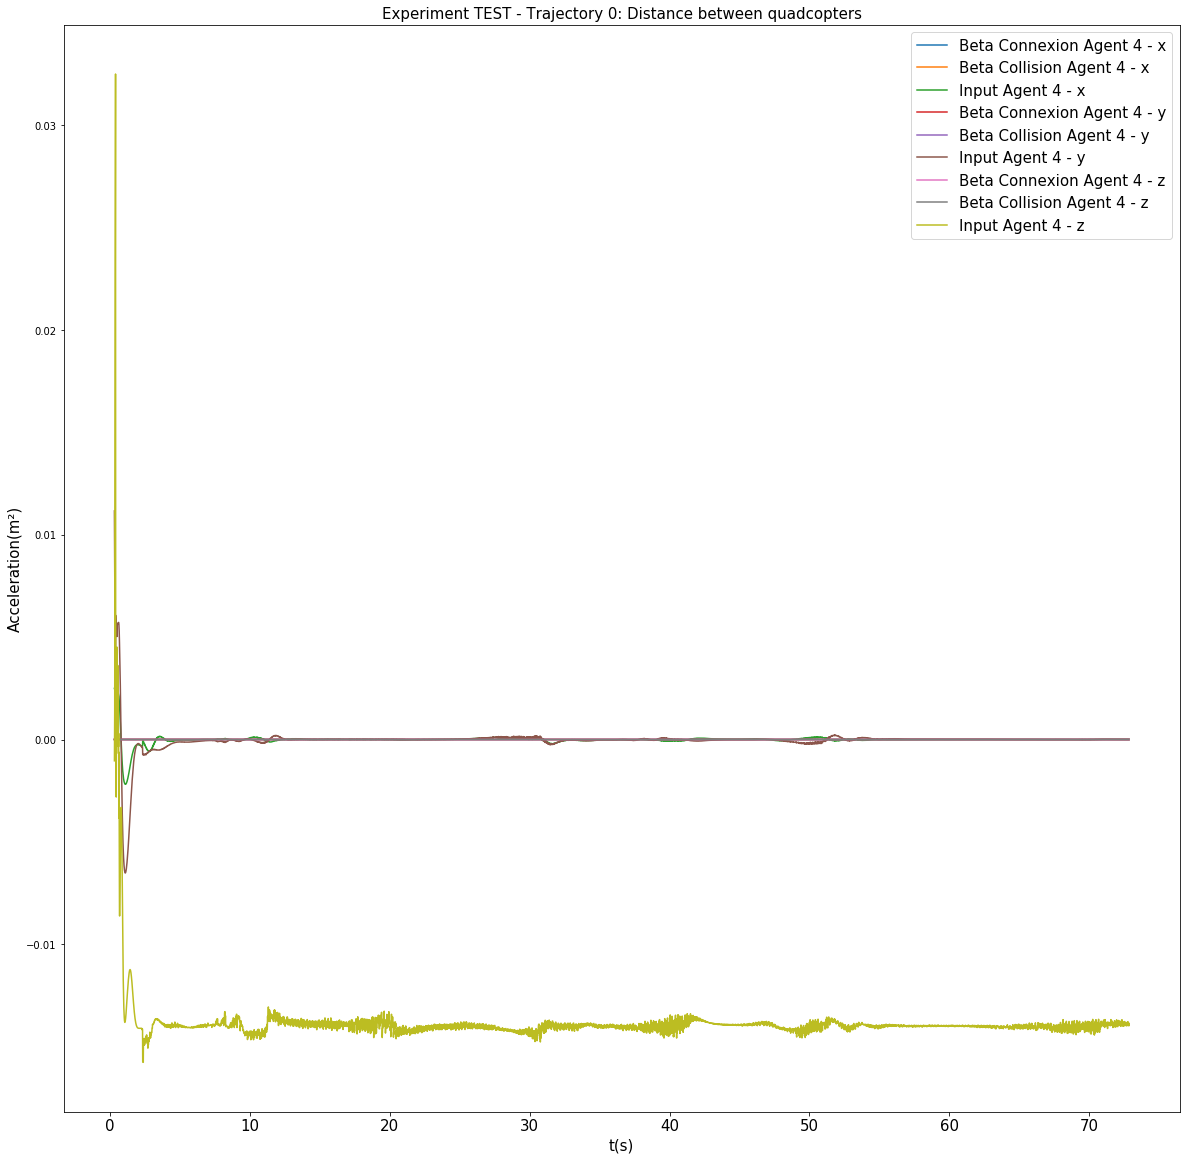

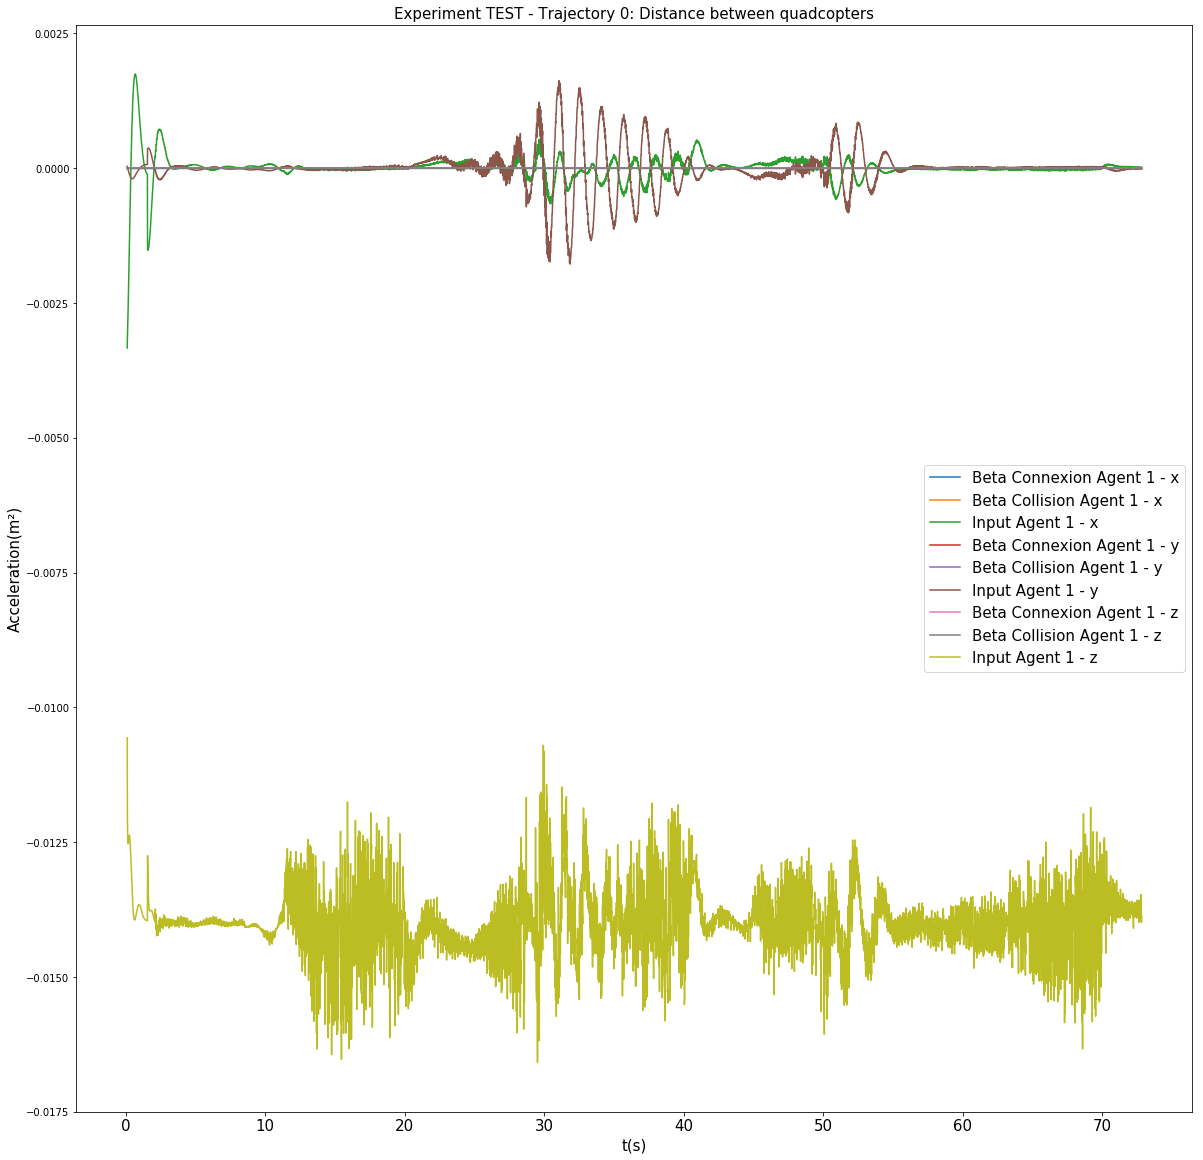

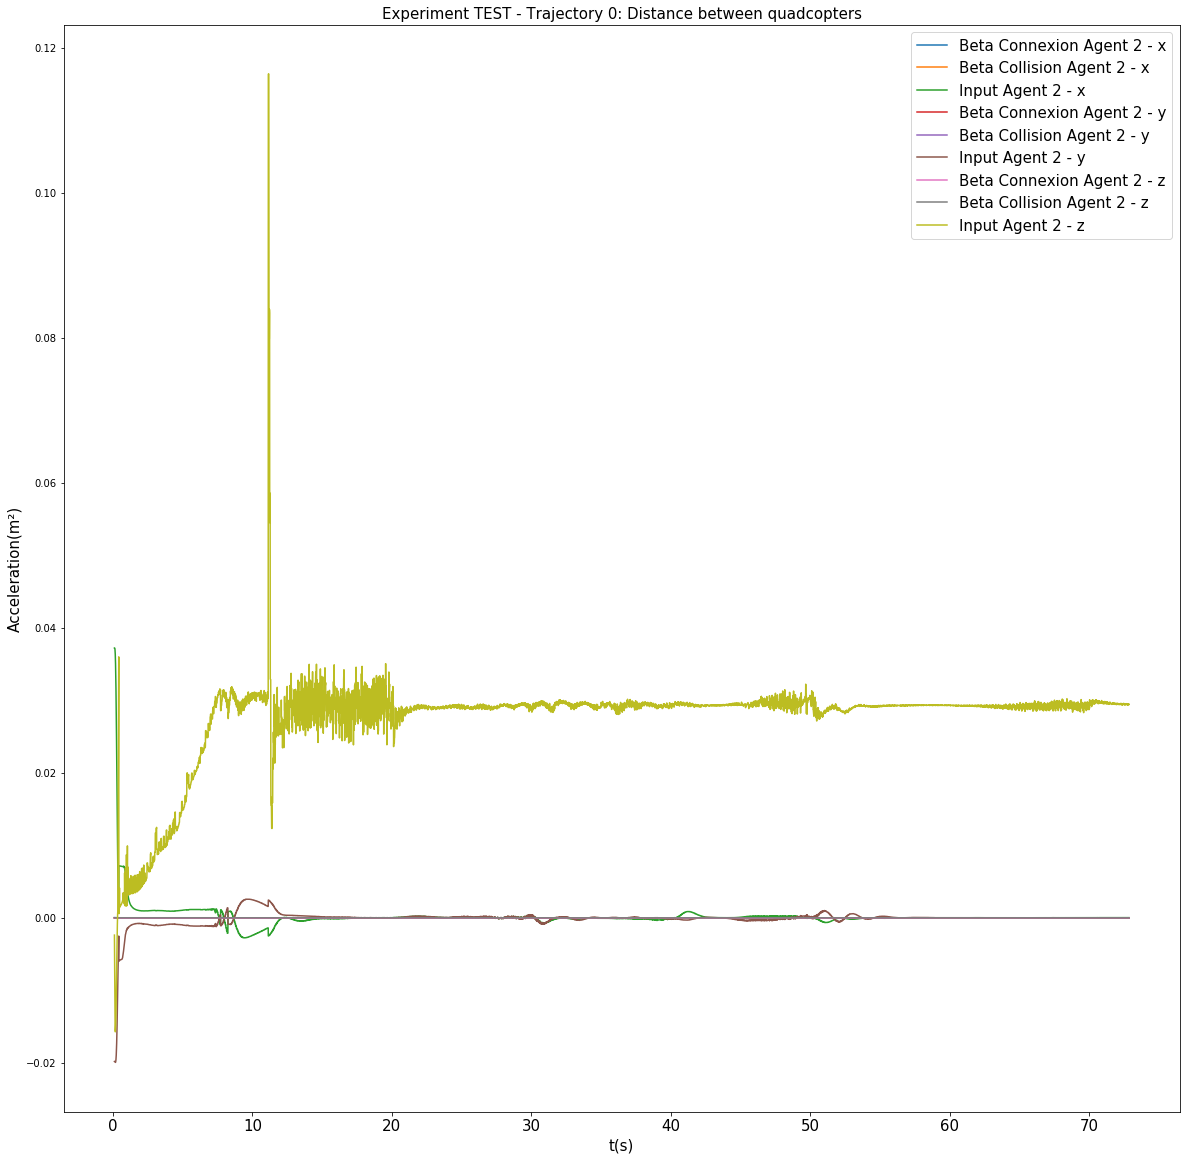

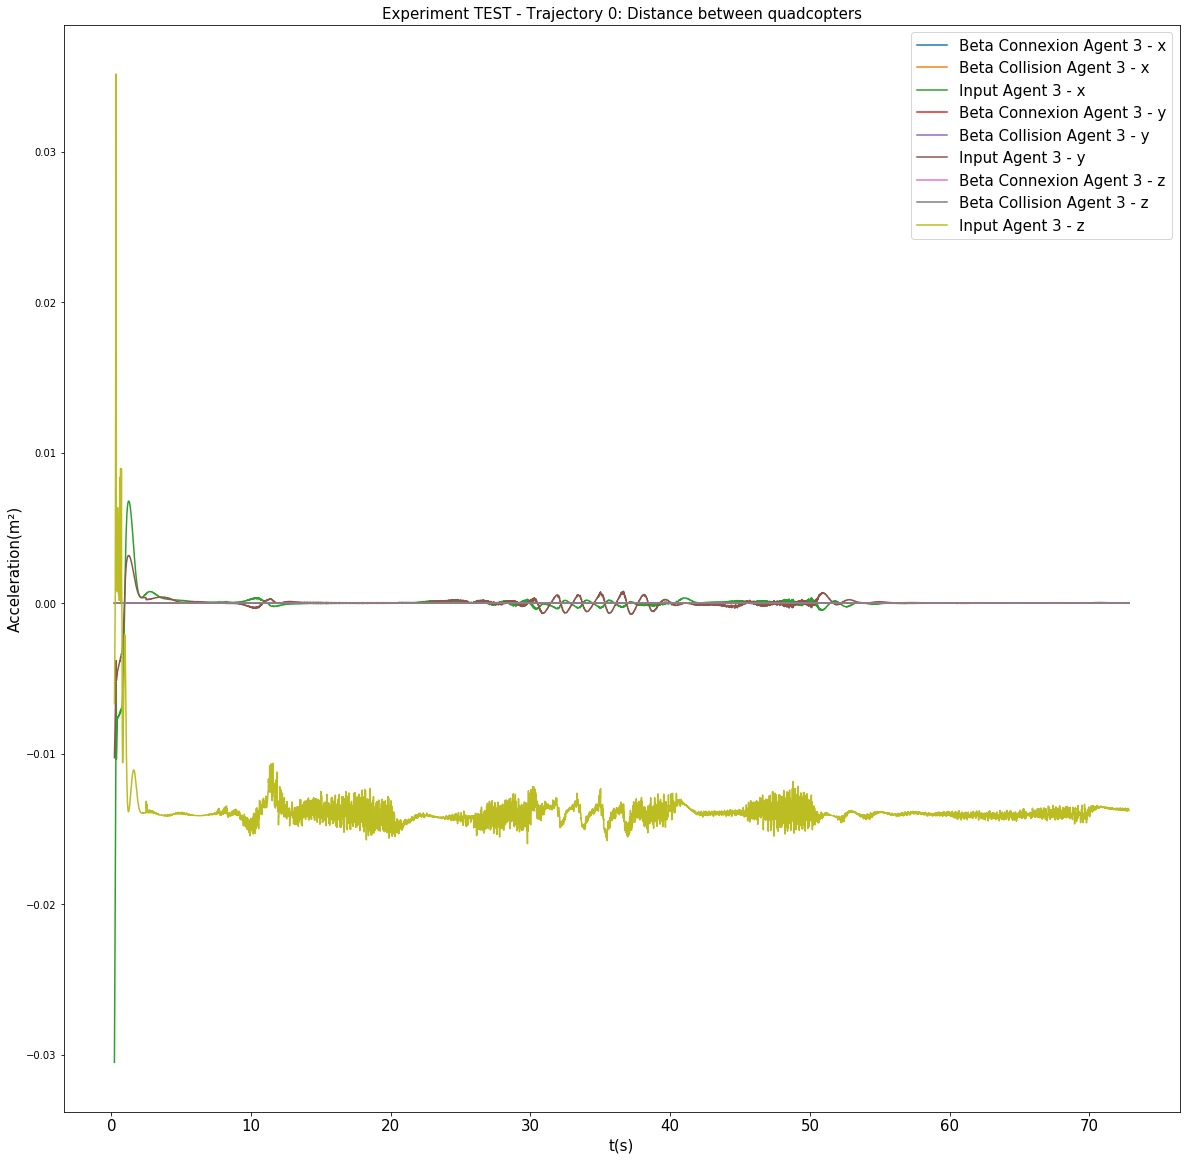

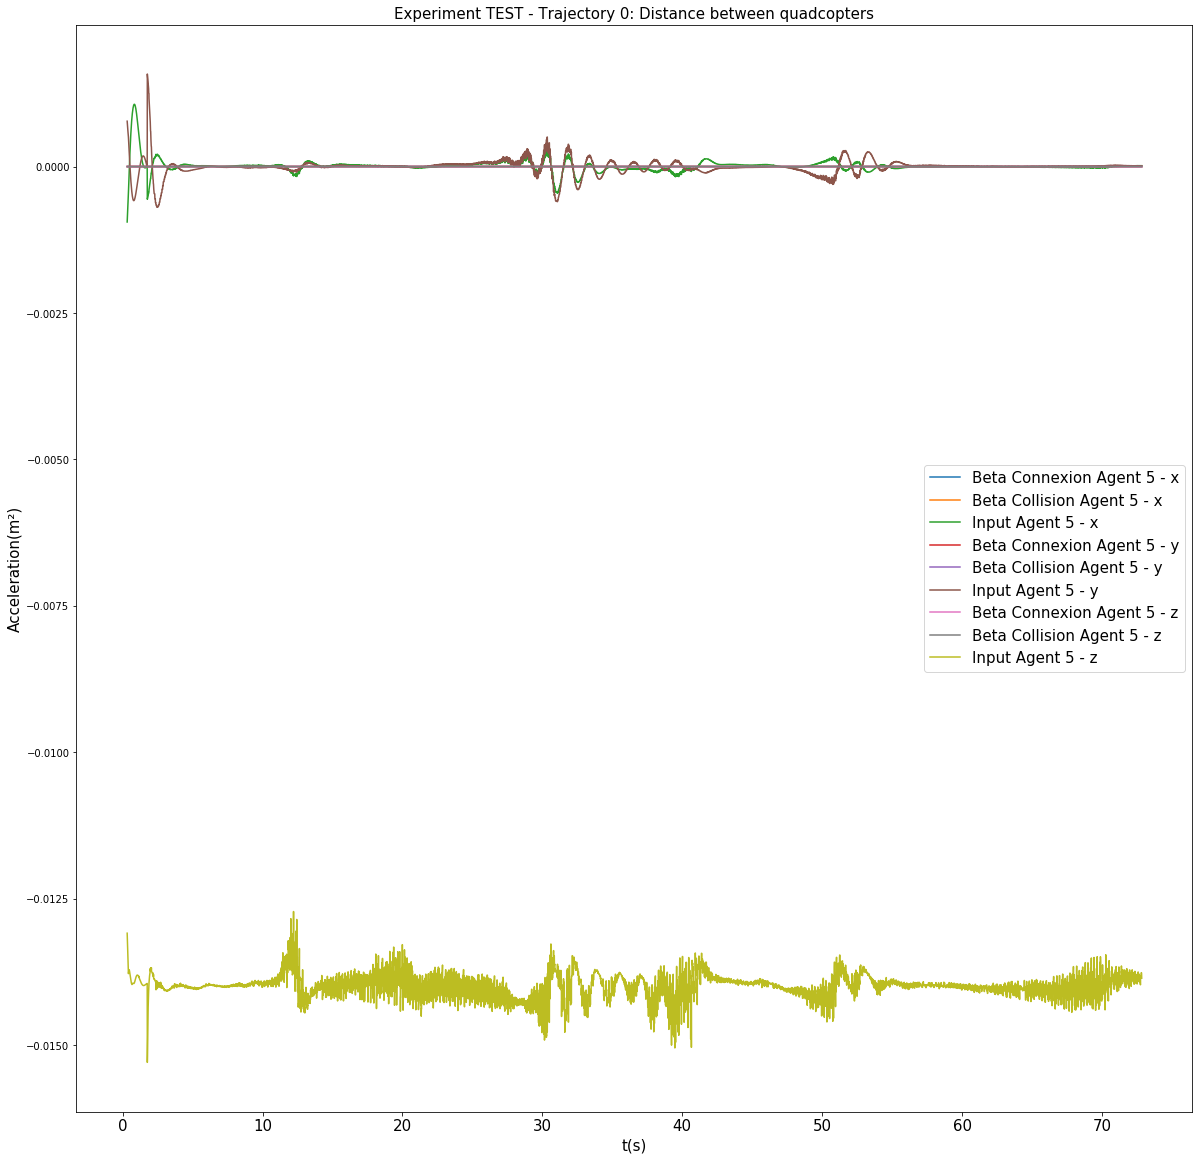

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(111)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 0], label = "Beta Connexion Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 0], label = "Beta Collision Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 0], label = "Input Agent " + drone.split("_")[1] + " - x")

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 1], label = "Beta Connexion Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 1], label = "Beta Collision Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 1], label = "Input Agent " + drone.split("_")[1] + " - y")

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 2], label = "Beta Connexion Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 2], label = "Beta Collision Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 2], label = "Input Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/3axis_betas_and_forces_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/3axis_betas_and_forces_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()


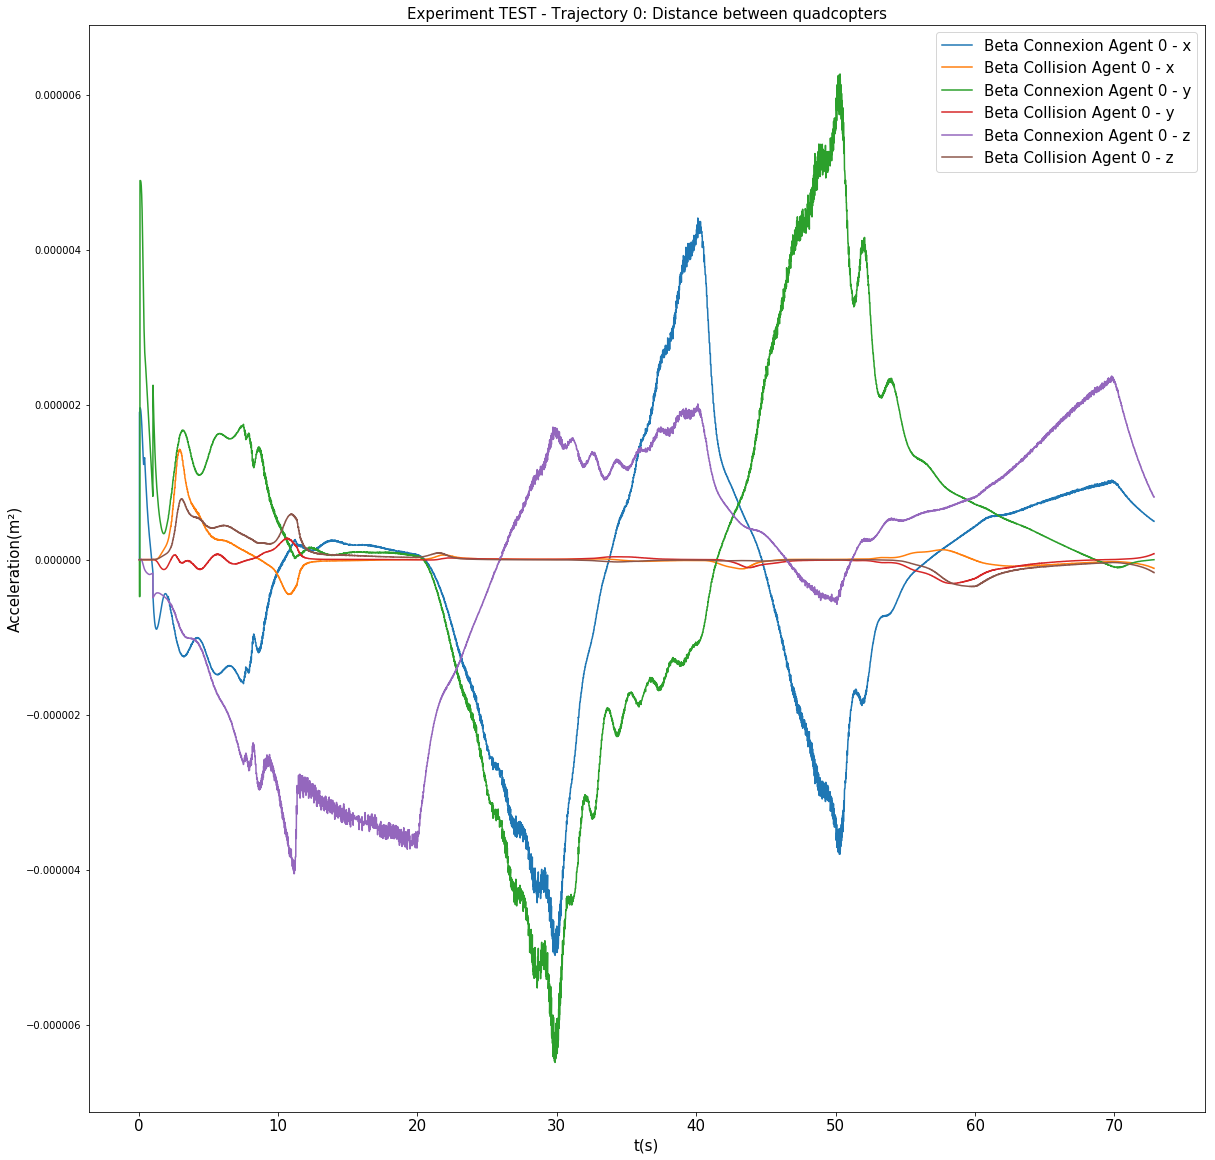

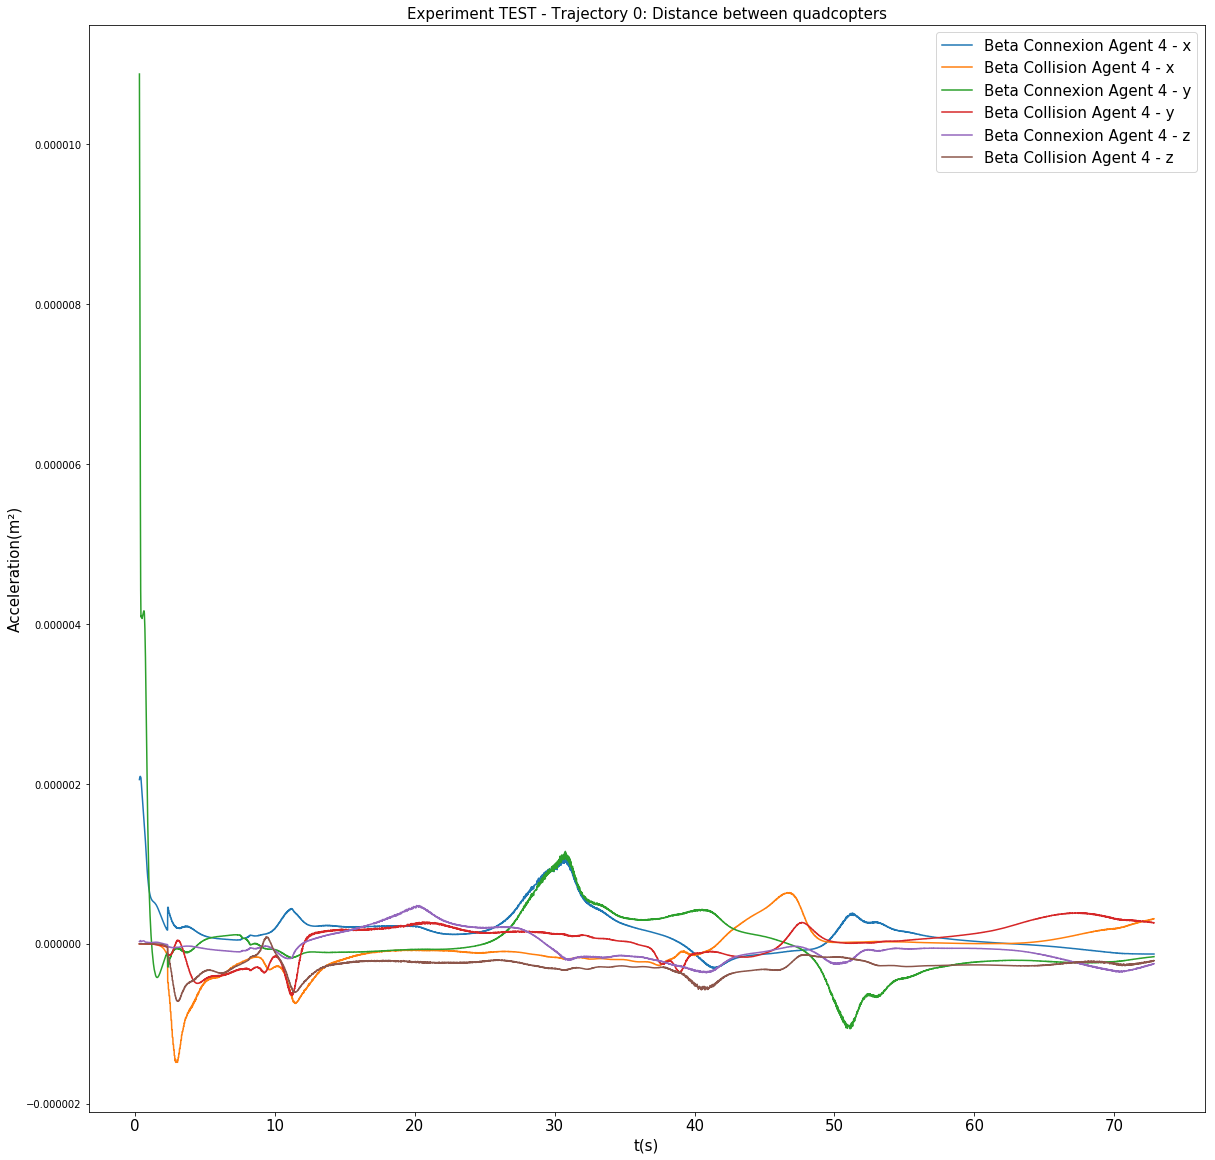

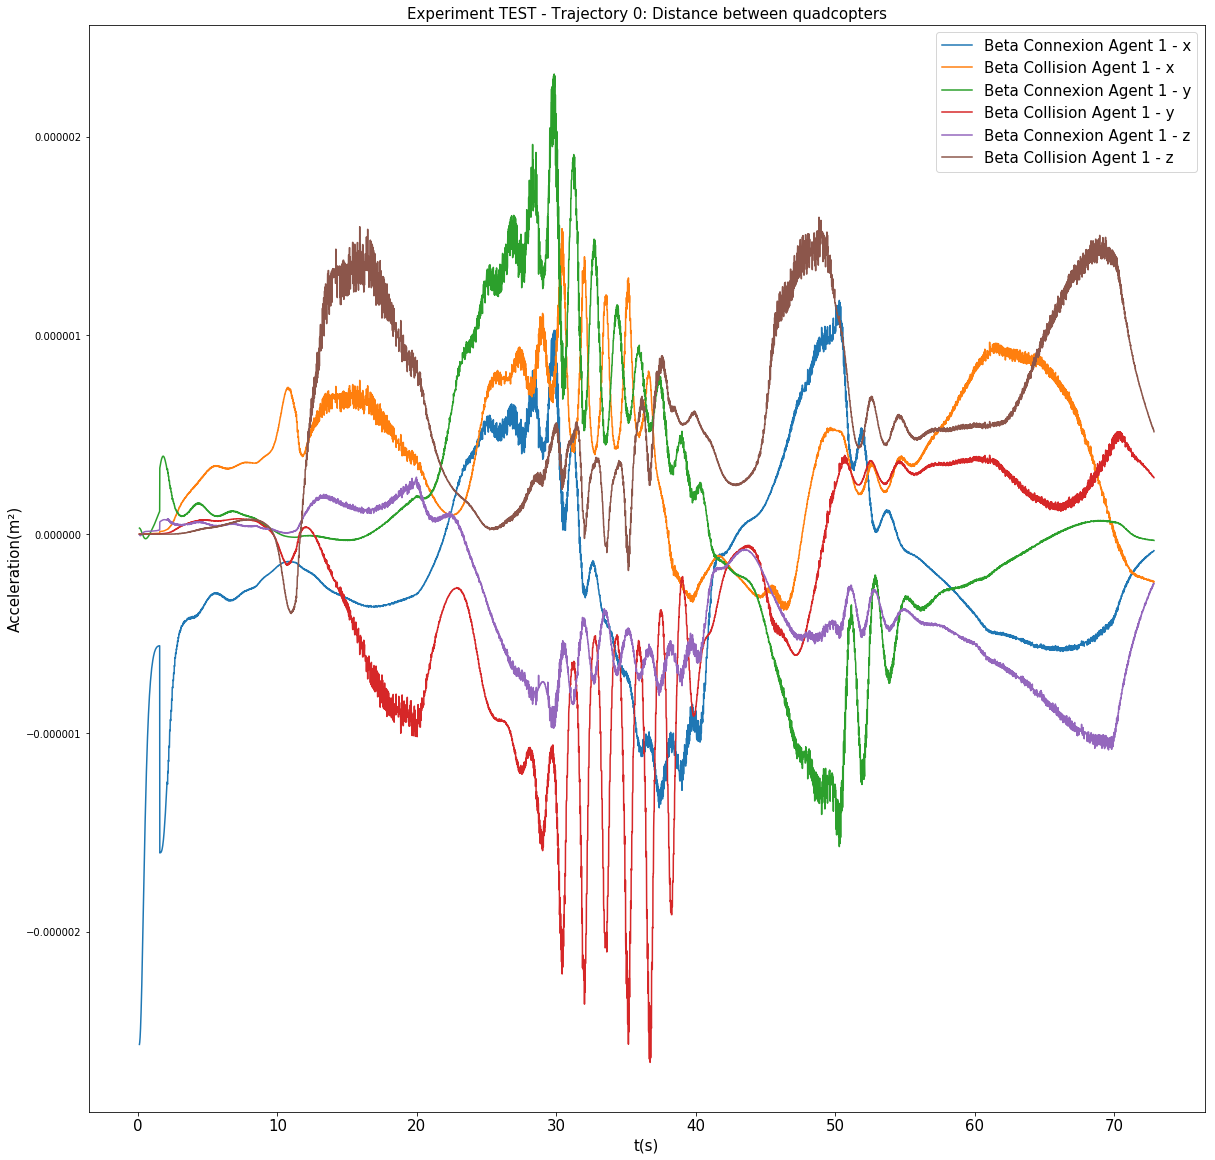

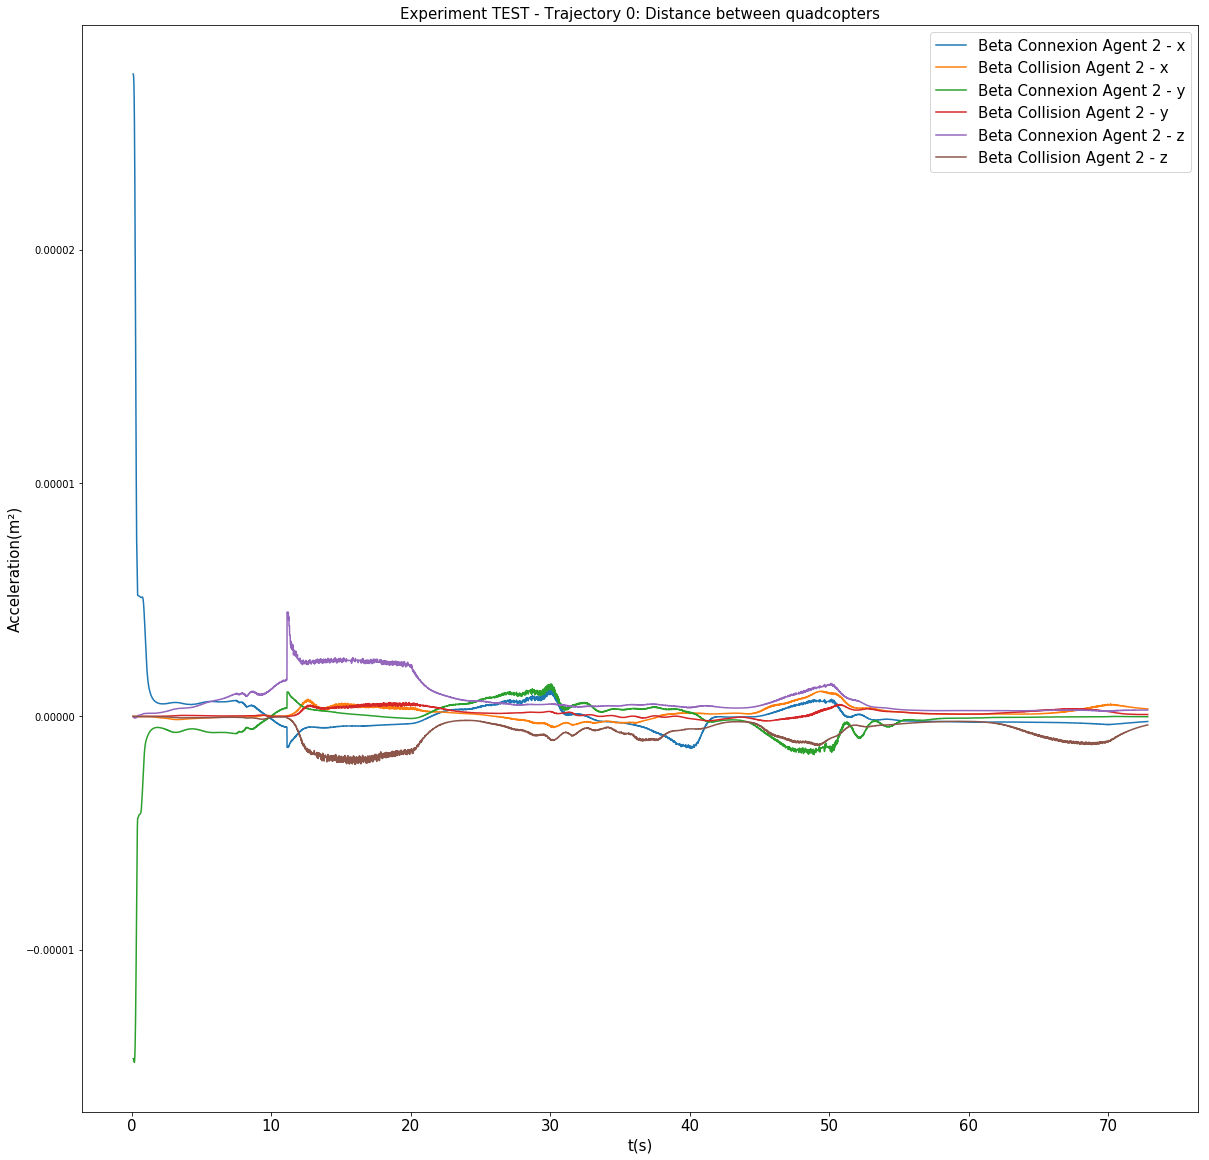

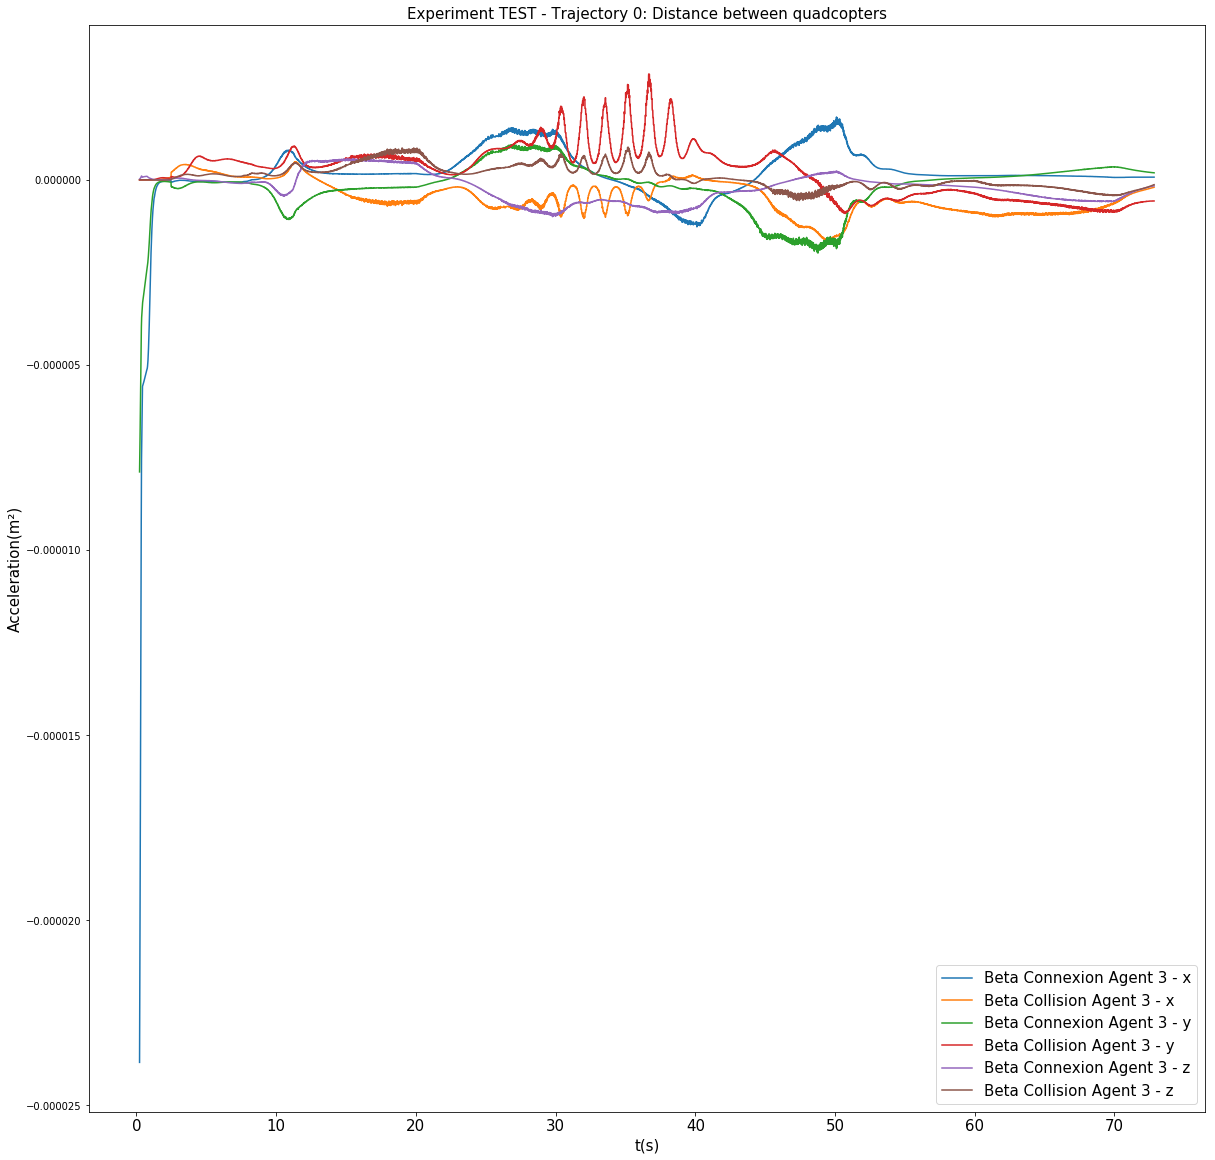

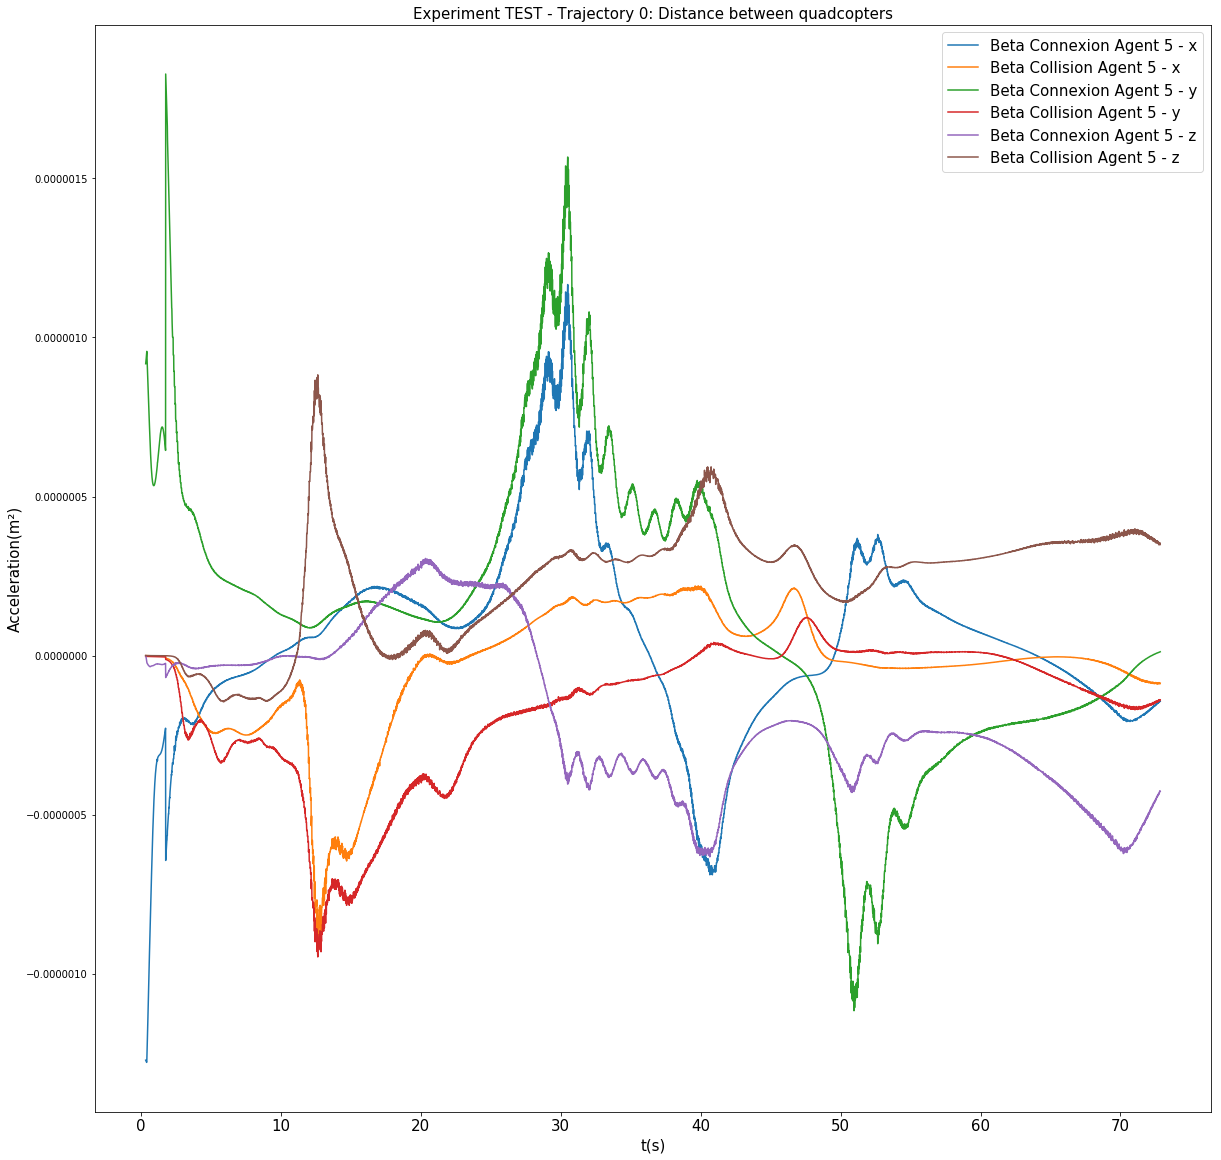

In [ ]:

import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(111)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 0], label = "Beta Connexion Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 0], label = "Beta Collision Agent " + drone.split("_")[1] + " - x")

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 1], label = "Beta Connexion Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 1], label = "Beta Collision Agent " + drone.split("_")[1] + " - y")

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 2], label = "Beta Connexion Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 2], label = "Beta Collision Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/3axis_betas_and_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/3axis_betas_and_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()

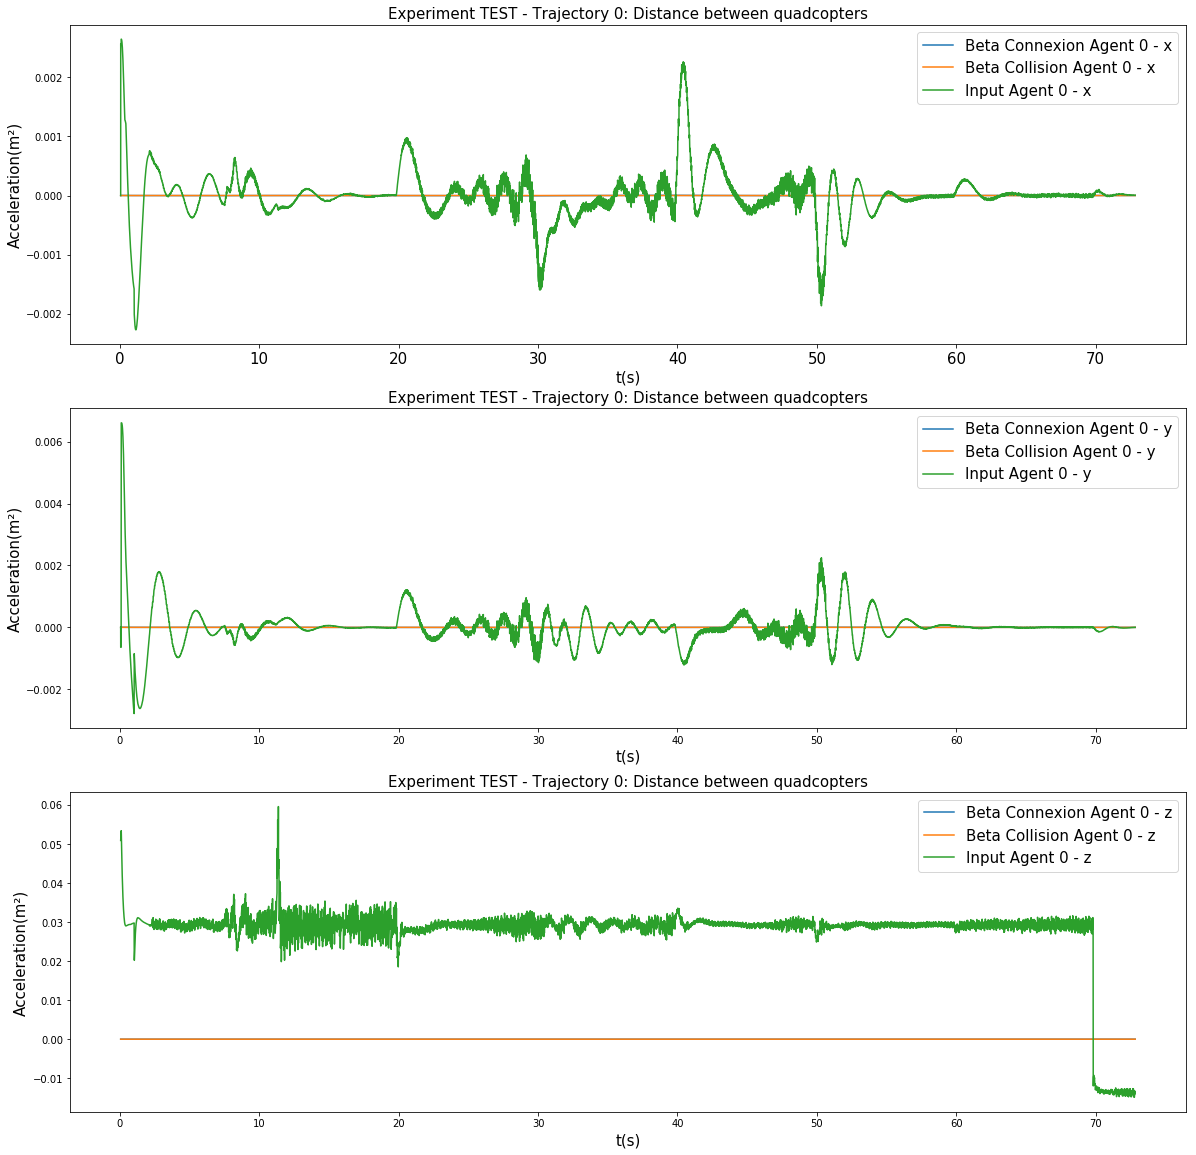

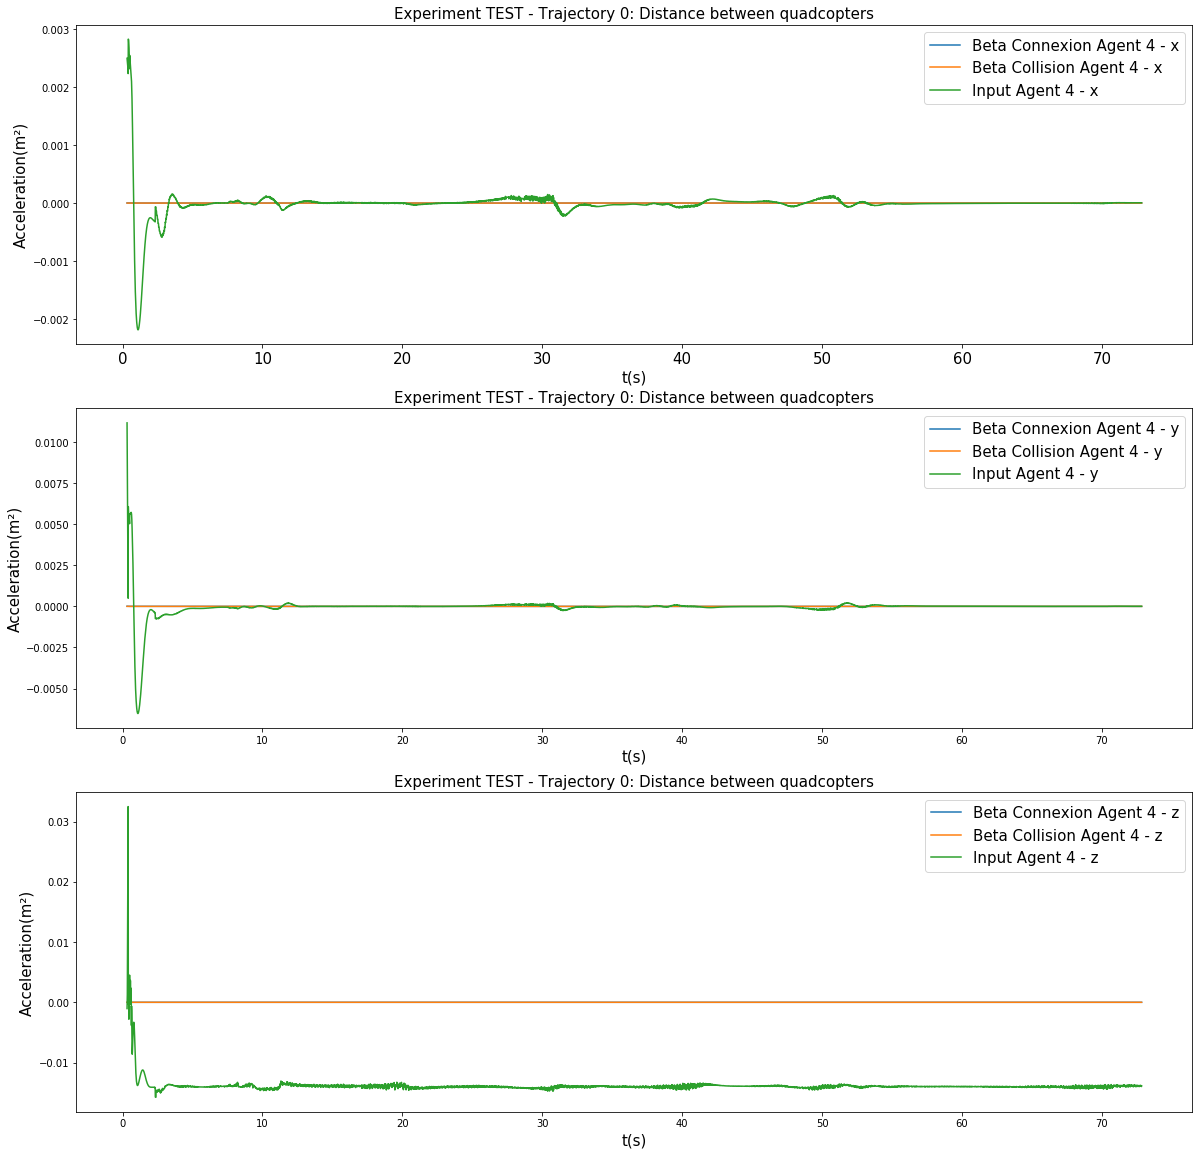

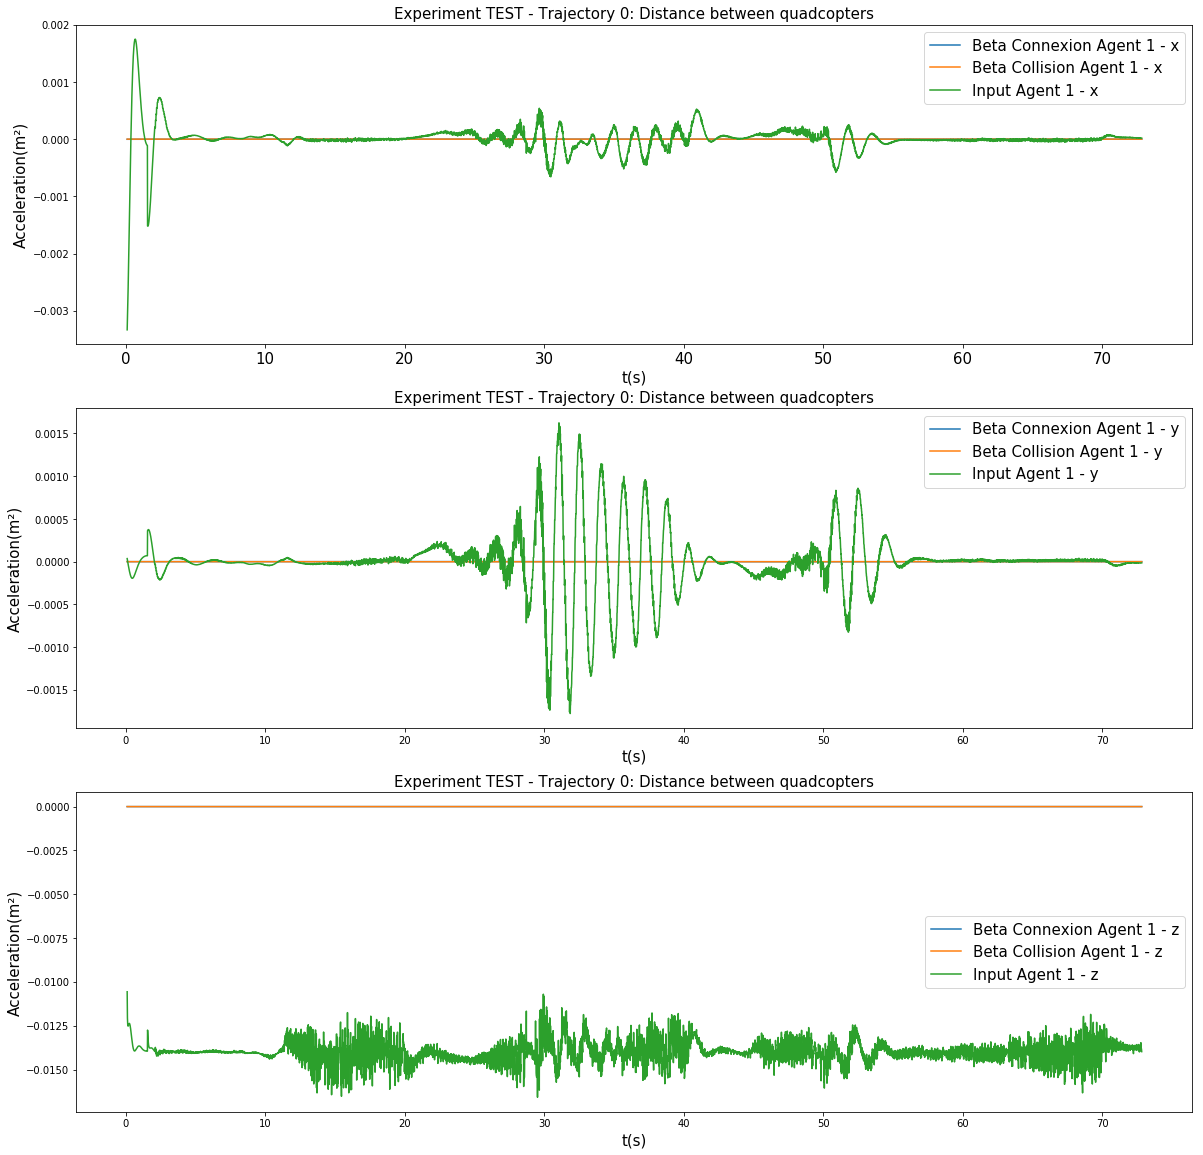

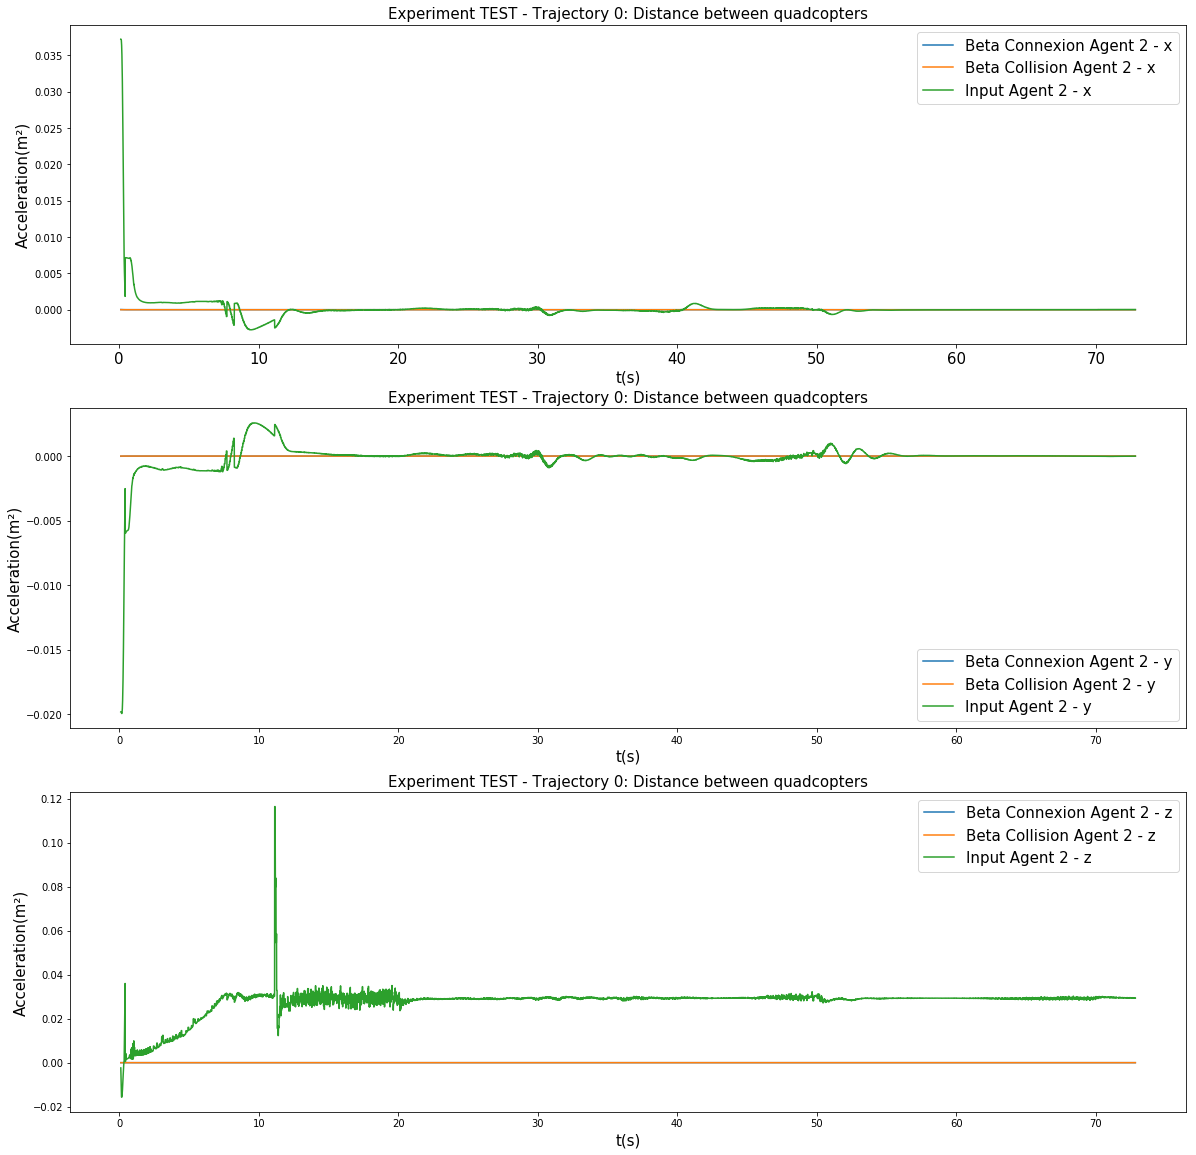

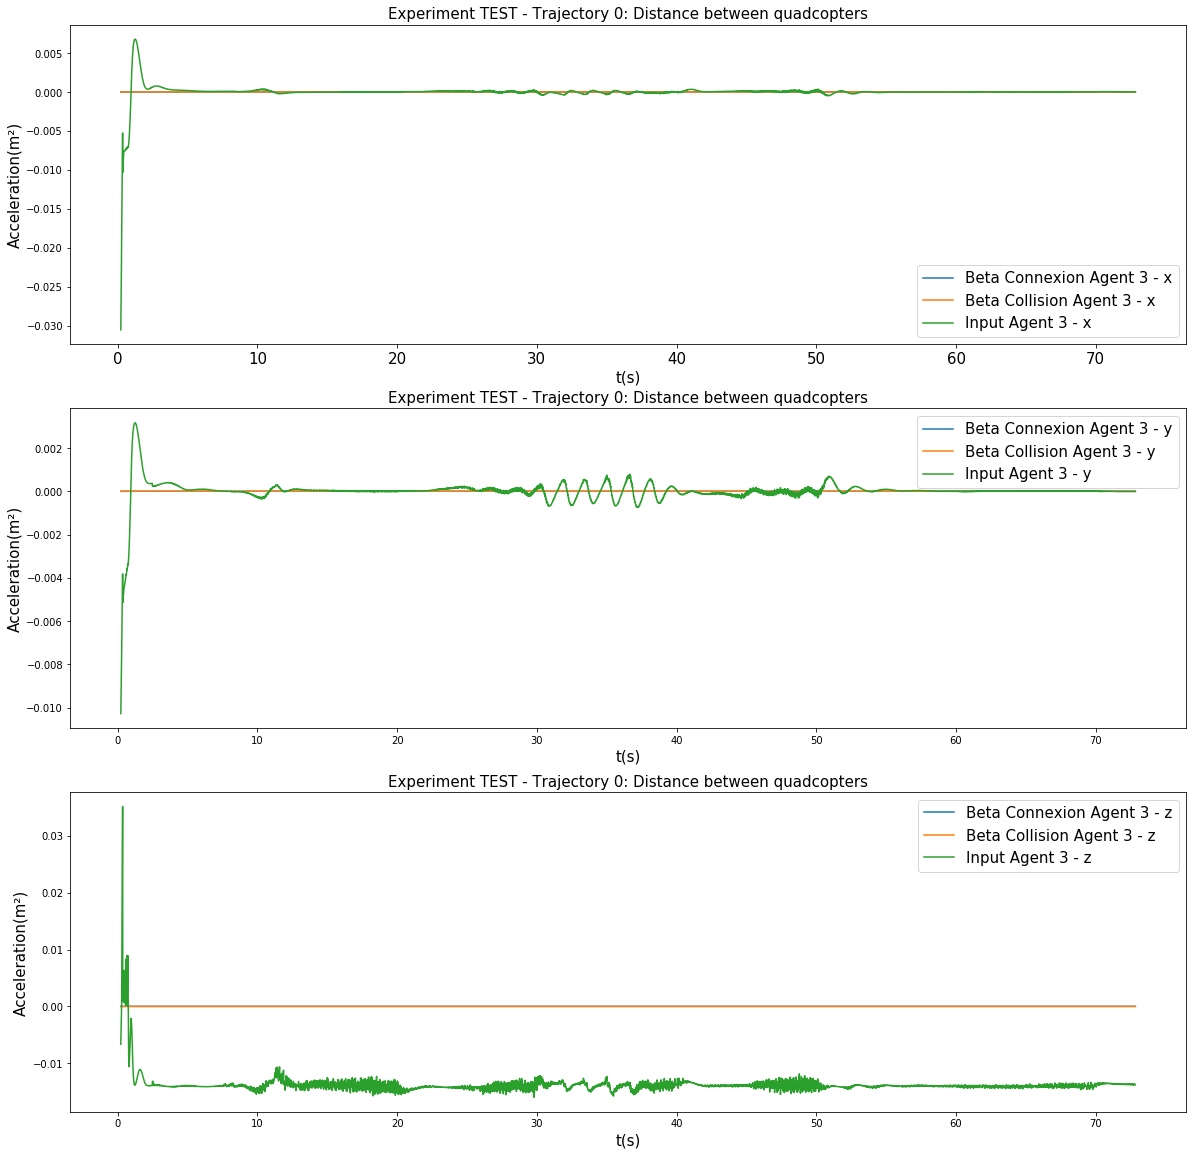

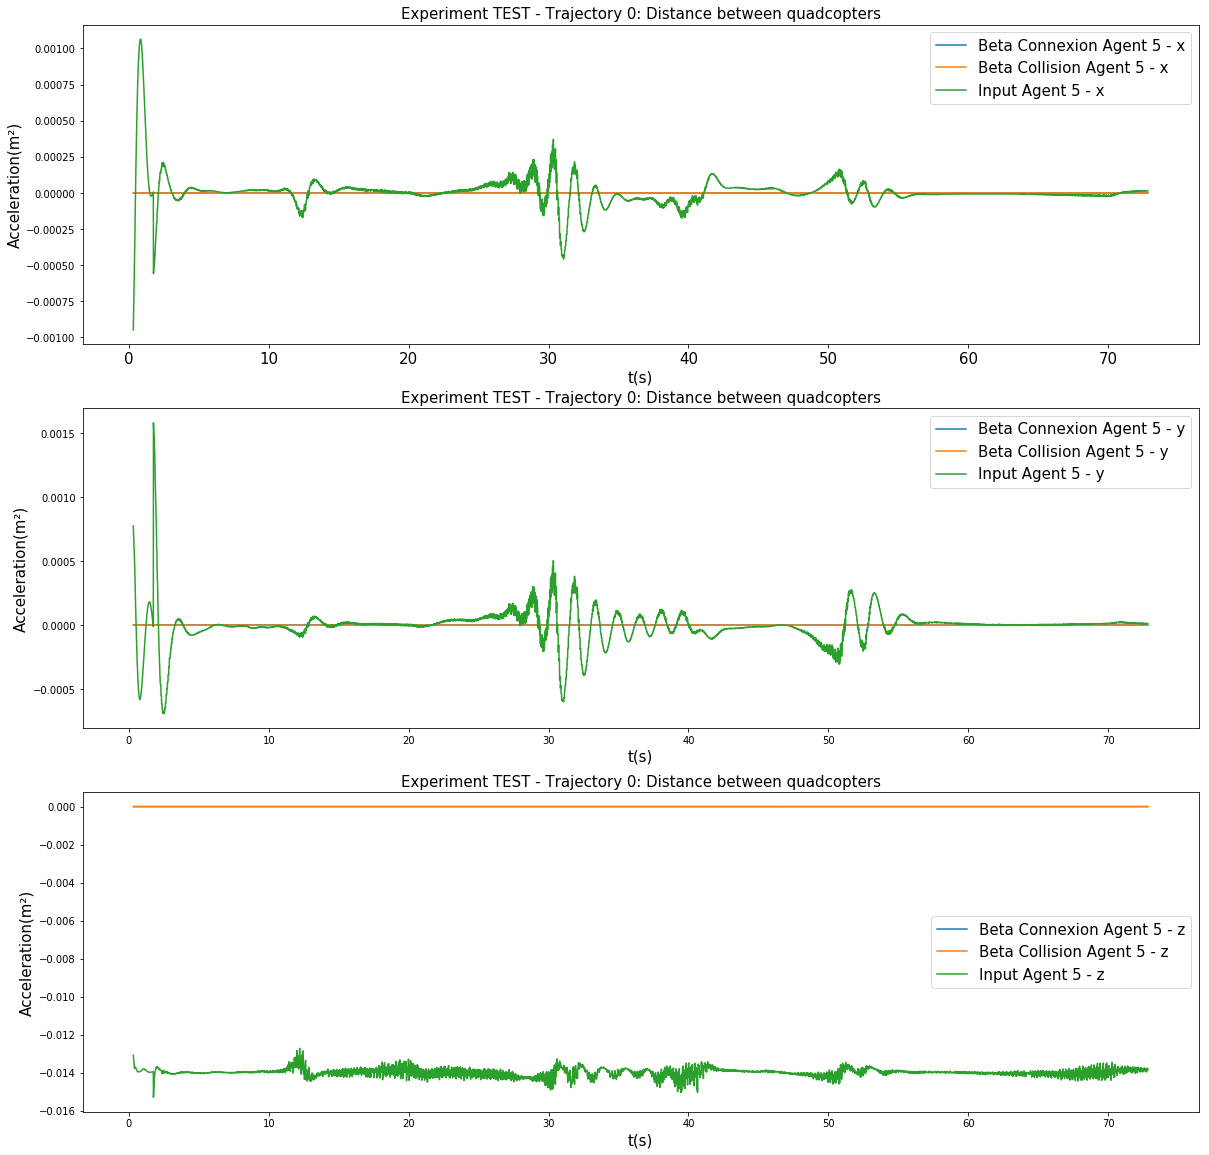

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(311)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 0], label = "Beta Connexion Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 0], label = "Beta Collision Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 0], label = "Input Agent " + drone.split("_")[1] + " - x")
        
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
    
        ax2 = plt.subplot(312)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 1], label = "Beta Connexion Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 1], label = "Beta Collision Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 1], label = "Input Agent " + drone.split("_")[1] + " - y")
       
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        
        ax3 = plt.subplot(313)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 2], label = "Beta Connexion Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 2], label = "Beta Collision Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 2], label = "Input Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/subplot_axis_betas_and_forces_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/subplot_axis_betas_and_forces_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()


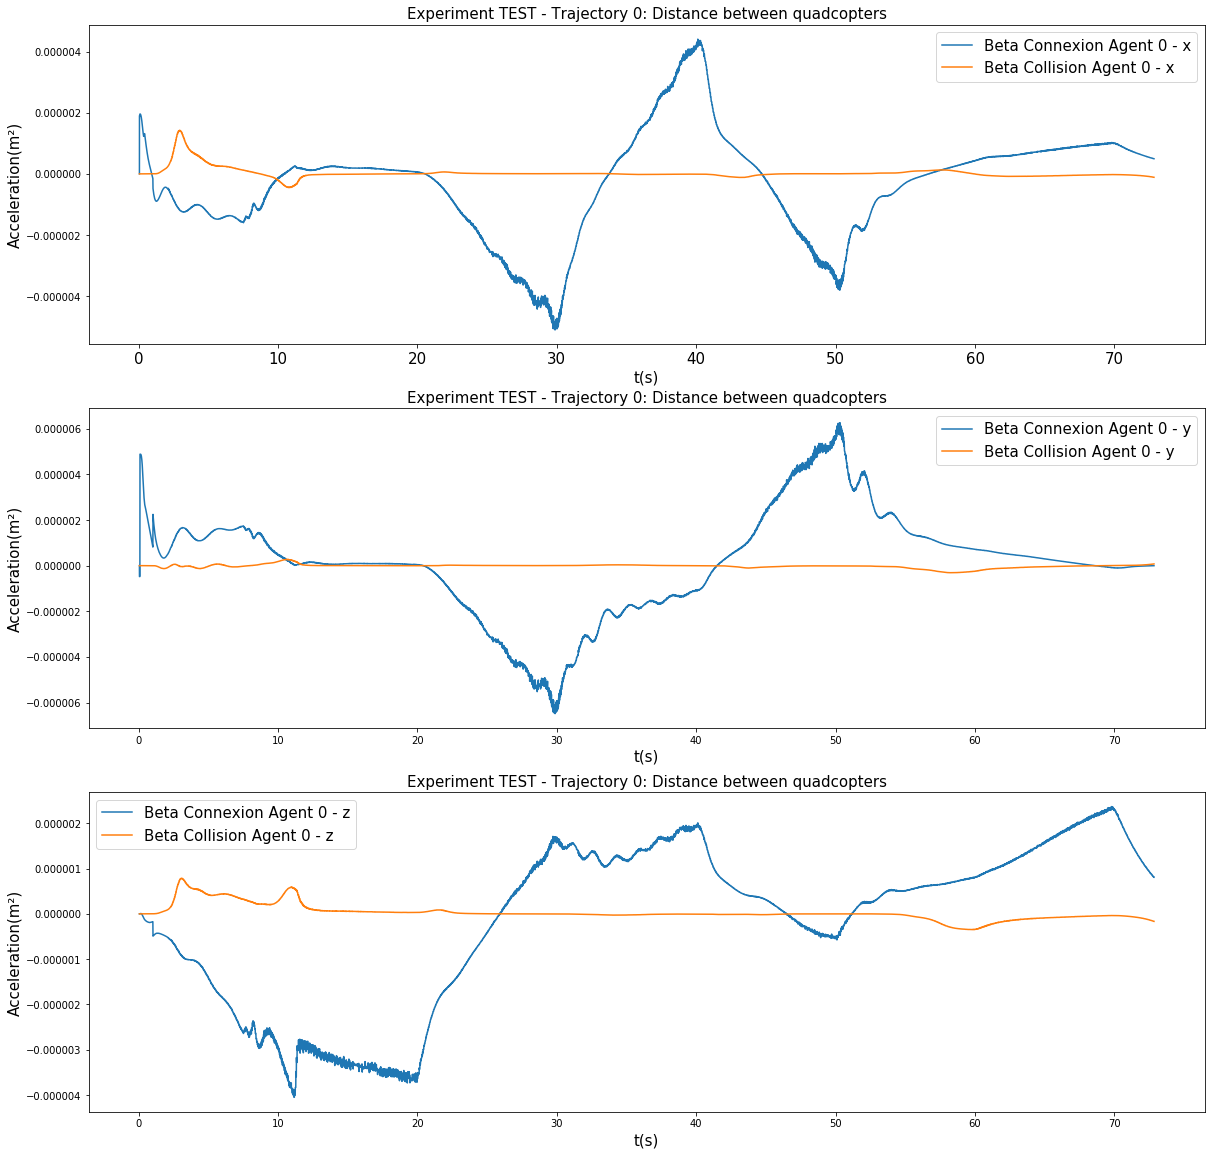

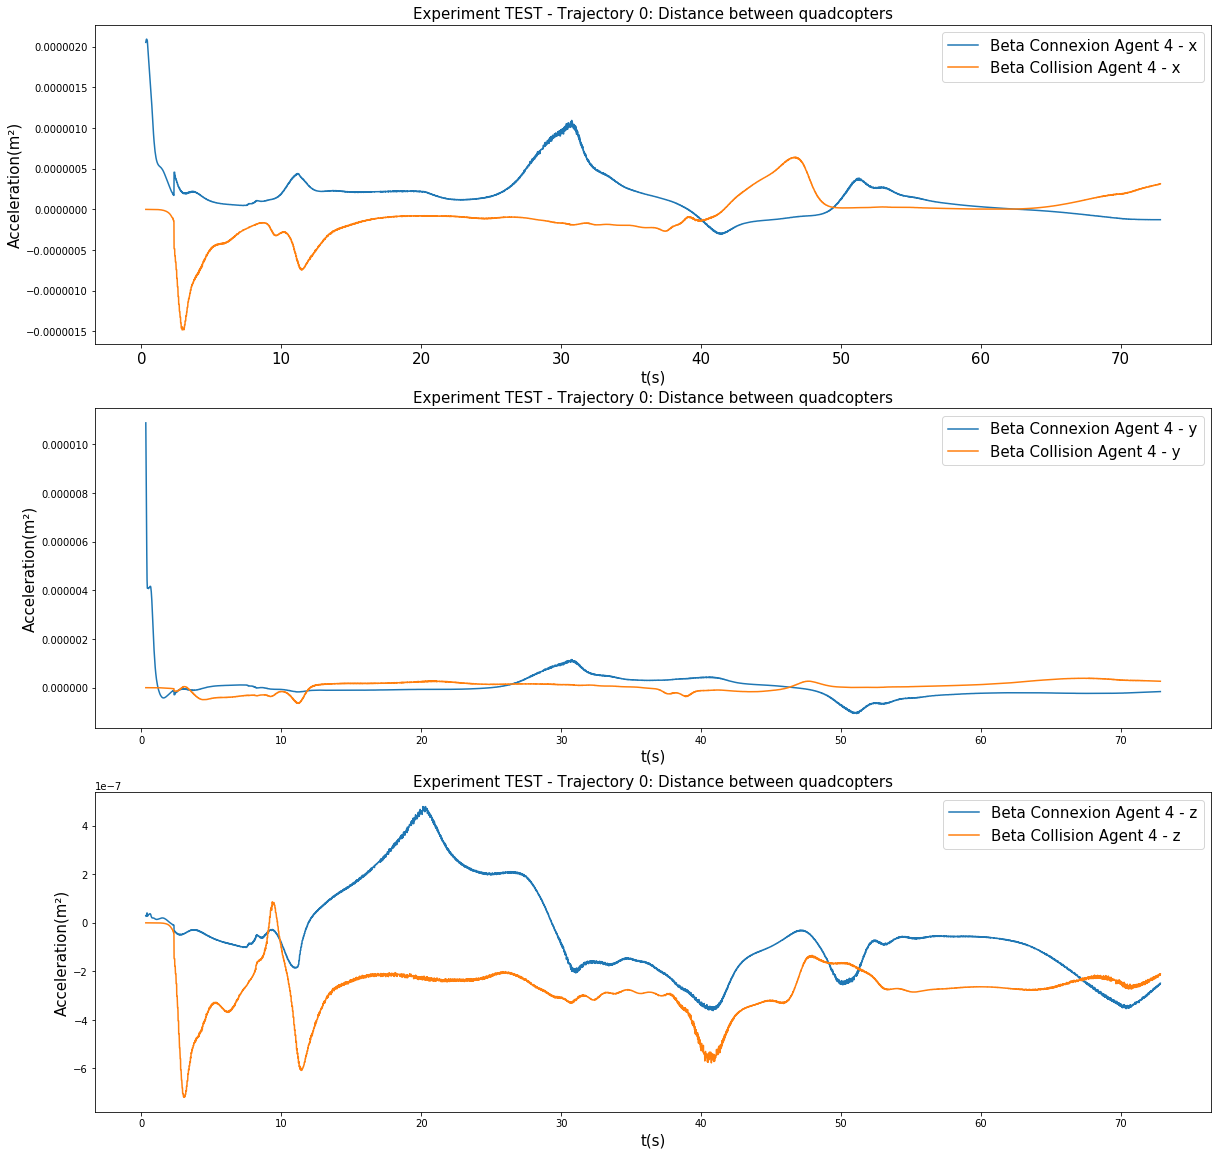

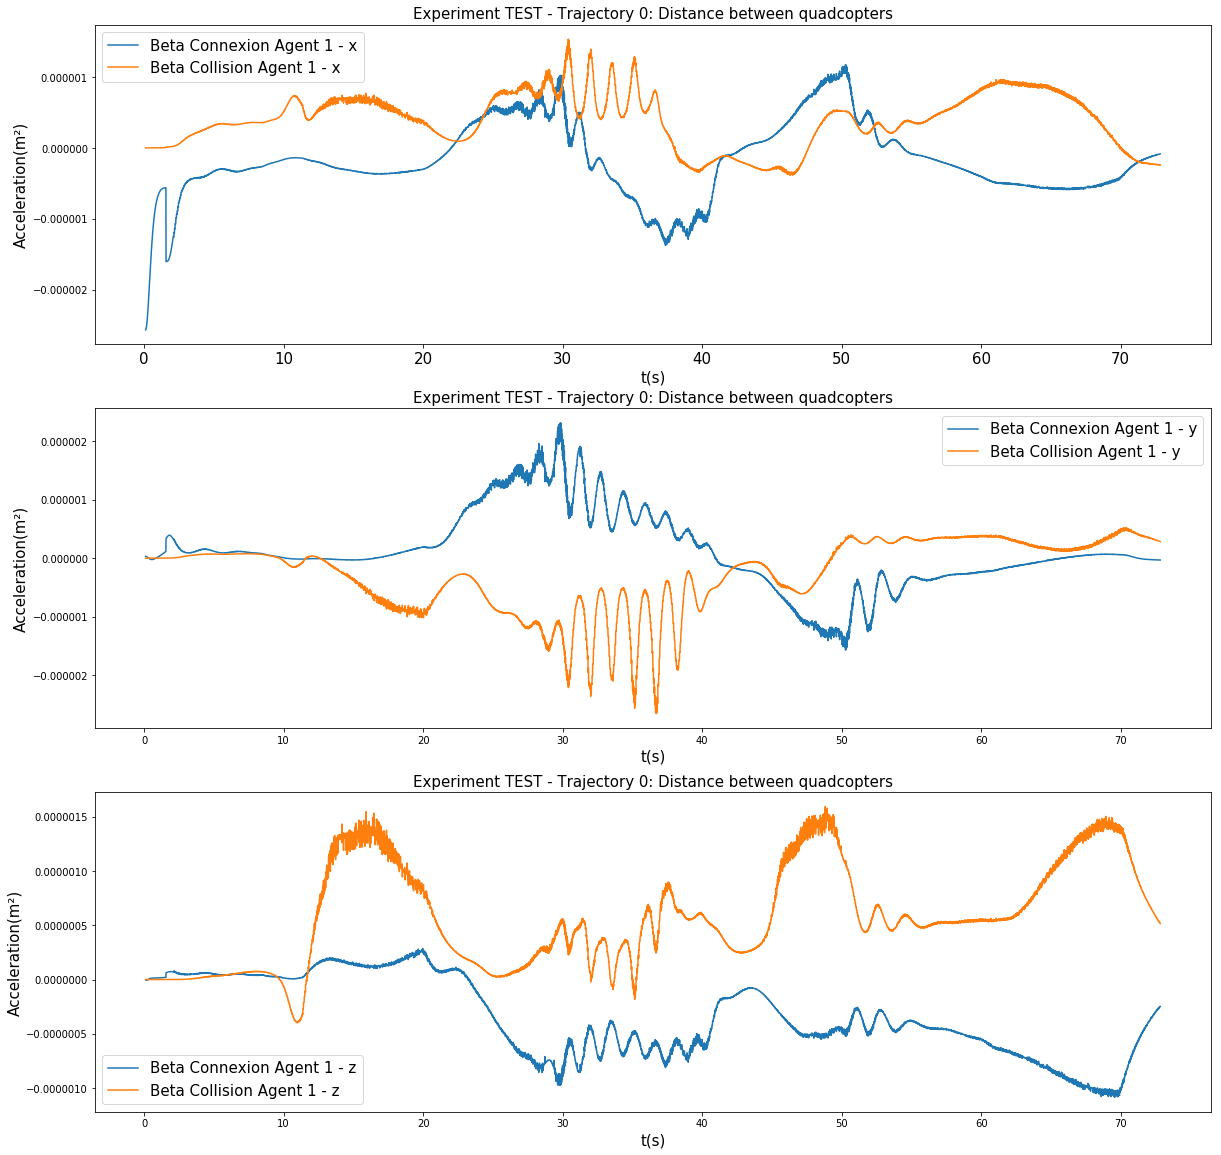

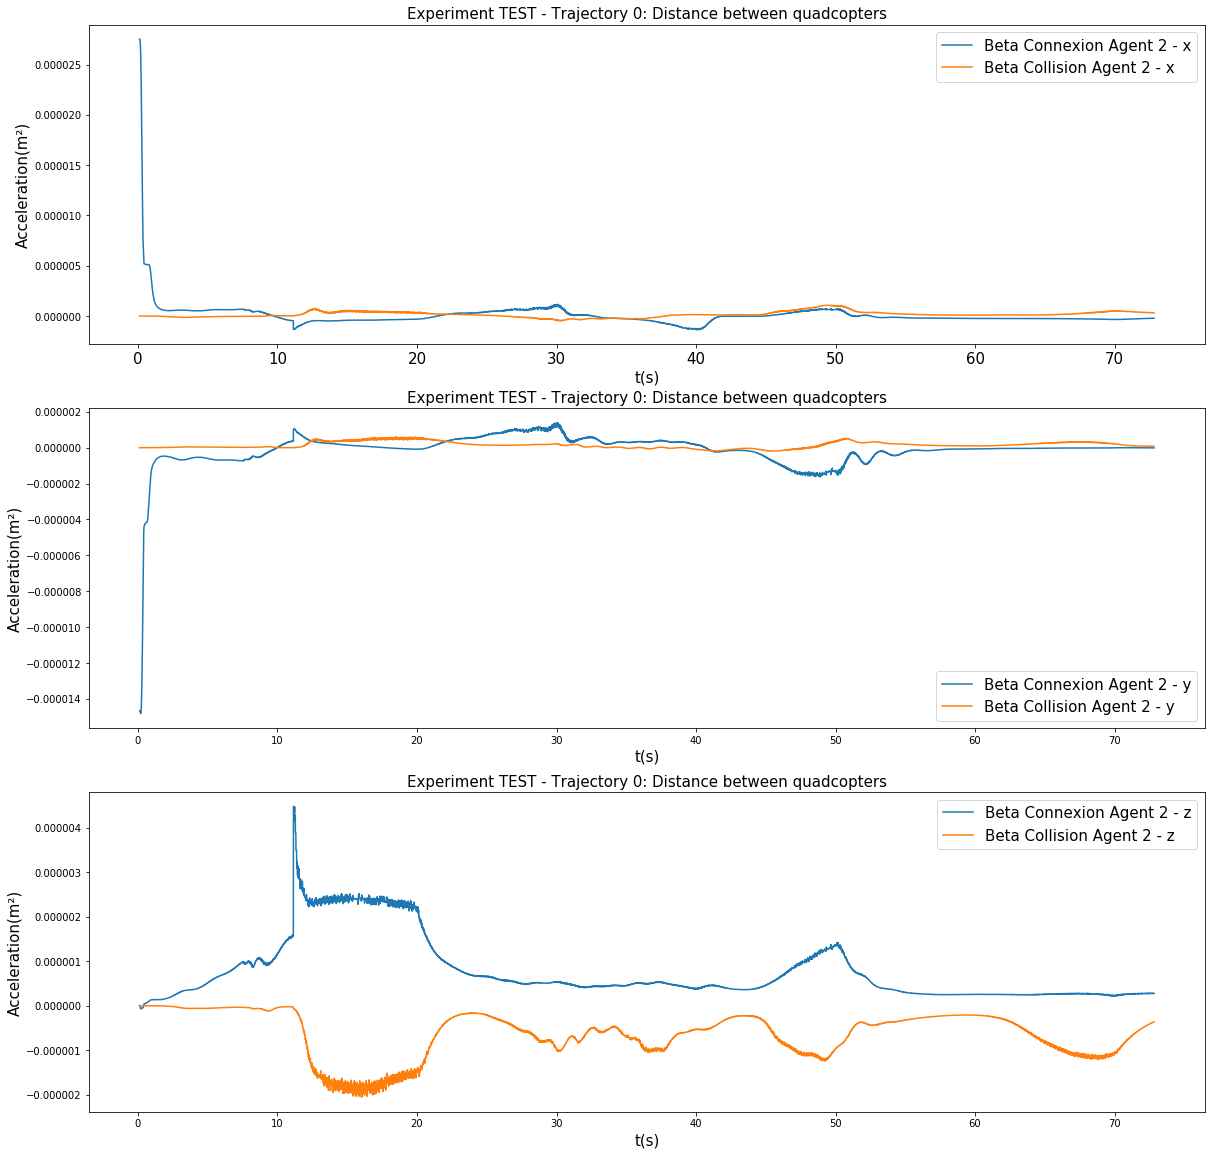

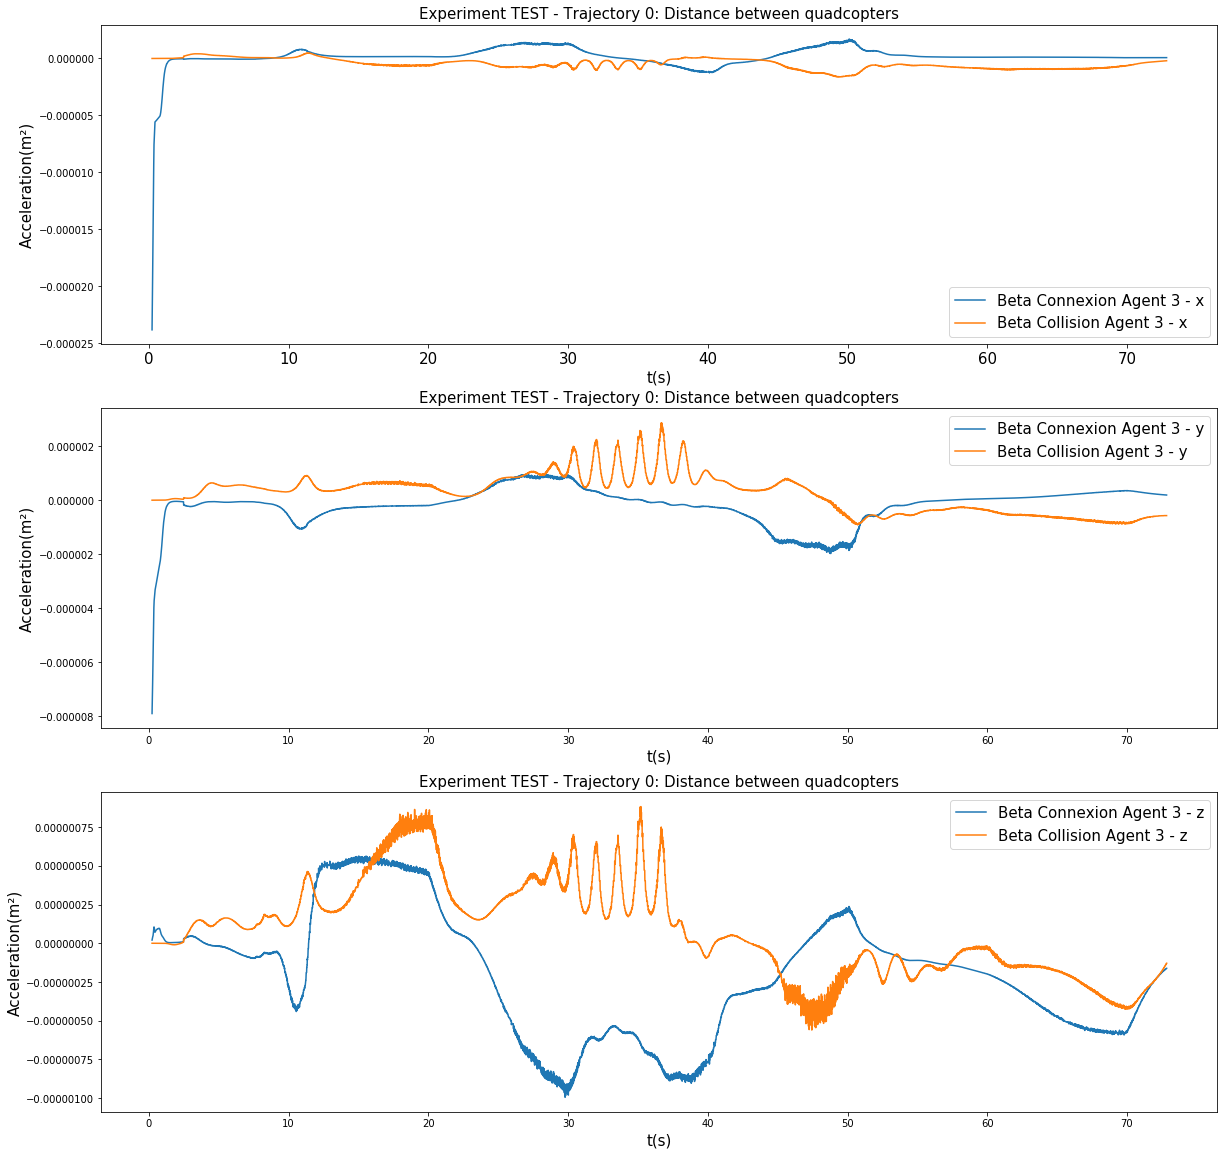

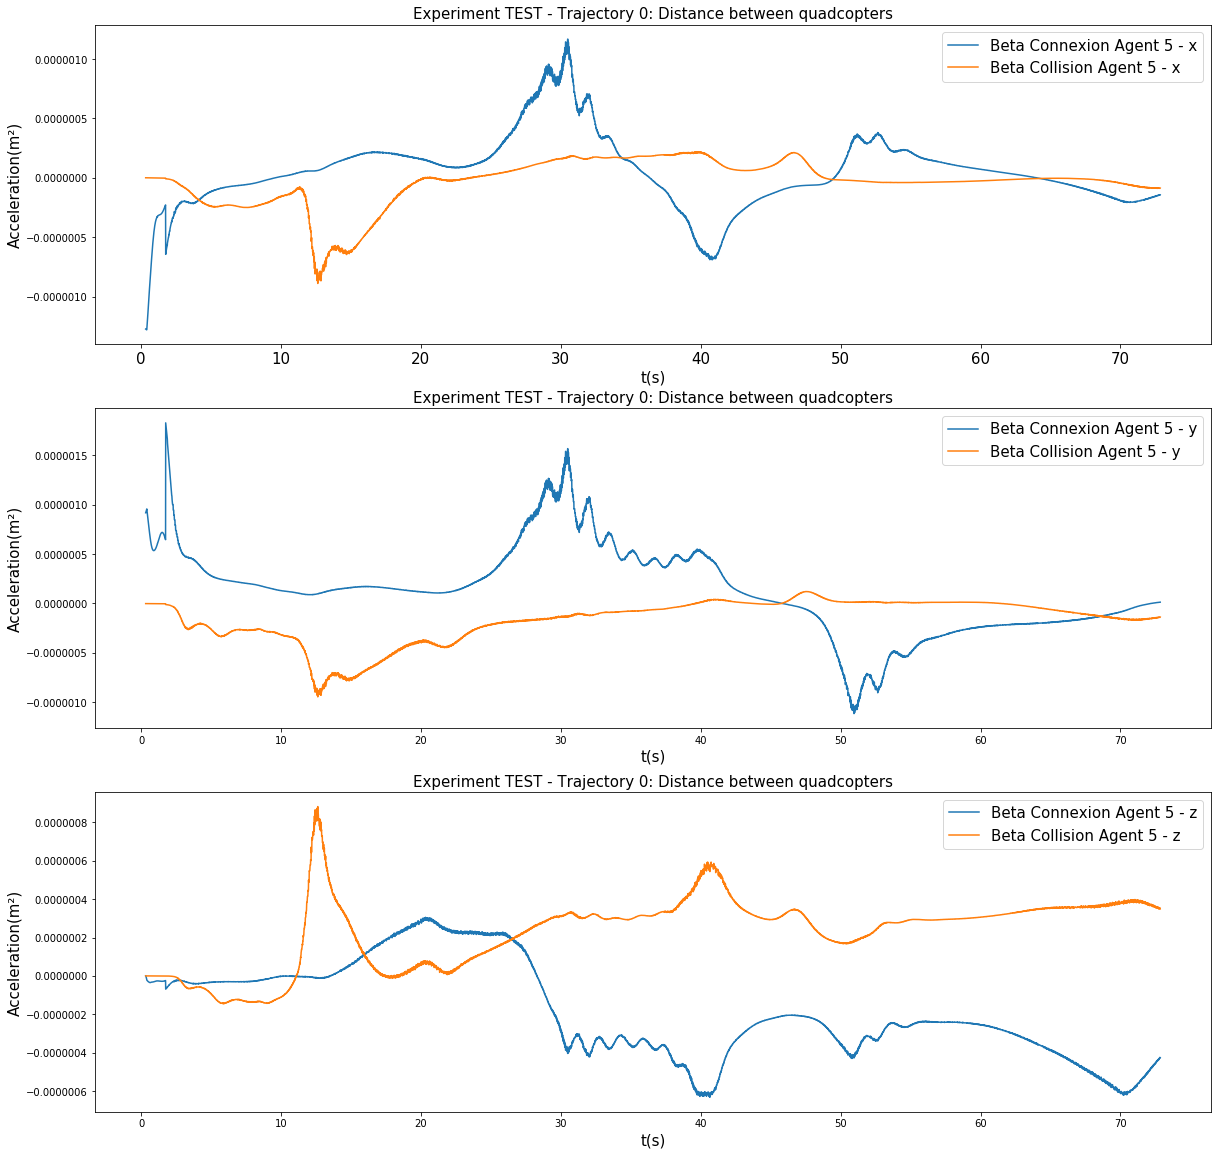

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(311)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 0], label = "Beta Connexion Agent " + drone.split("_")[1] + " - x")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 0], label = "Beta Collision Agent " + drone.split("_")[1] + " - x")
        
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
    
        ax2 = plt.subplot(312)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 1], label = "Beta Connexion Agent " + drone.split("_")[1] + " - y")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 1], label = "Beta Collision Agent " + drone.split("_")[1] + " - y")
       
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        
        ax3 = plt.subplot(313)

        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_con"][:, 2], label = "Beta Connexion Agent " + drone.split("_")[1] + " - z")
        plt.plot( data[experiment]["betas_" + drone]["time"], forcesBetas[experiment][drone]["beta_col"][:, 2], label = "Beta Collision Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/subplot_axis_betas_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/subplot_axis_betas_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()

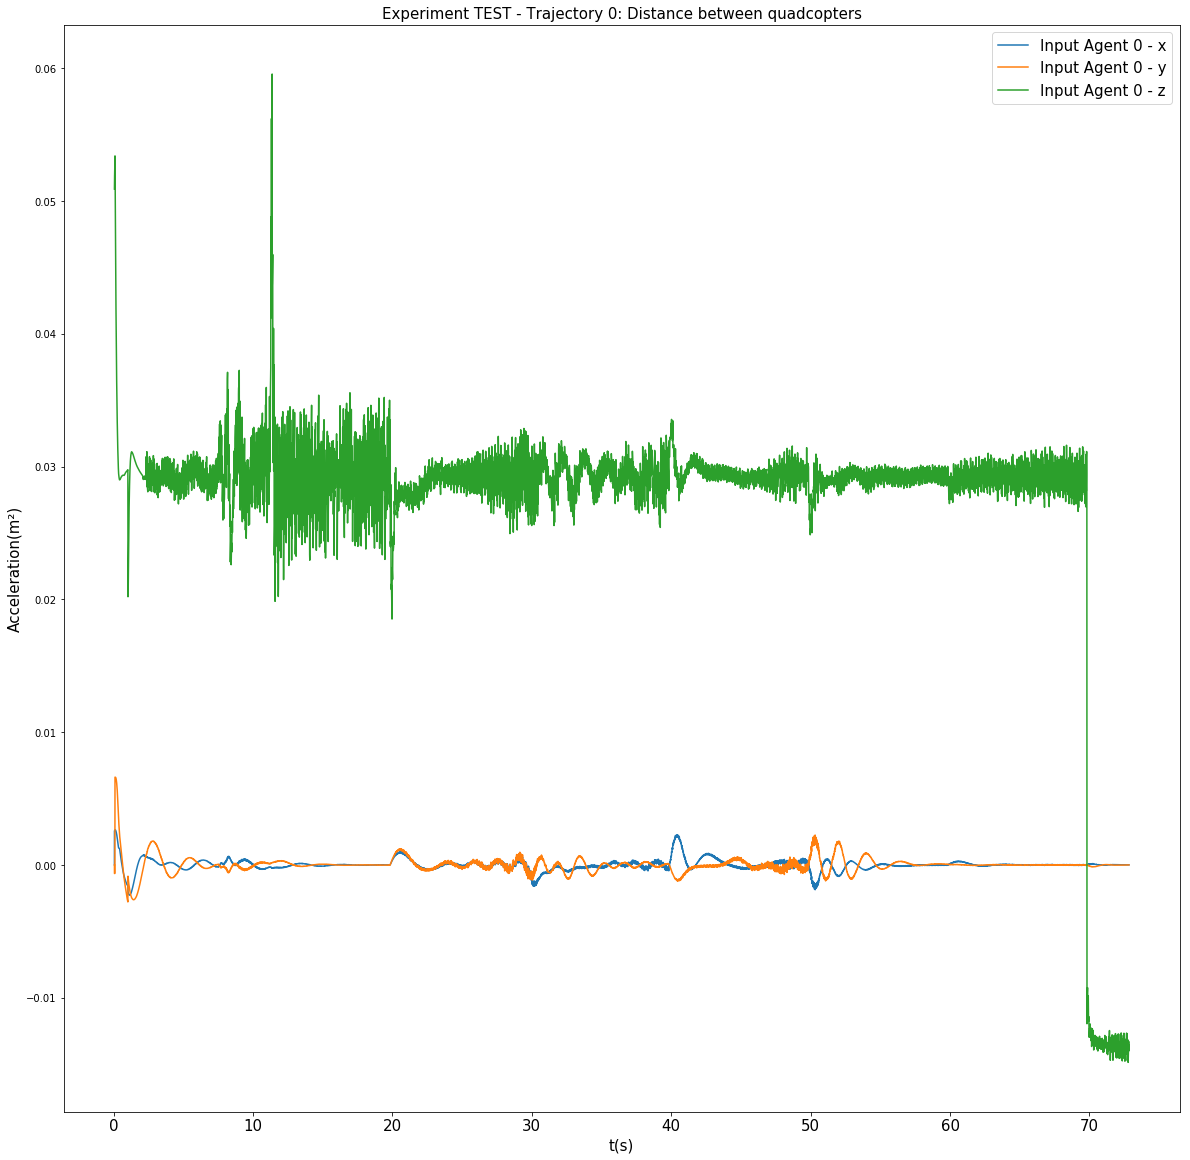

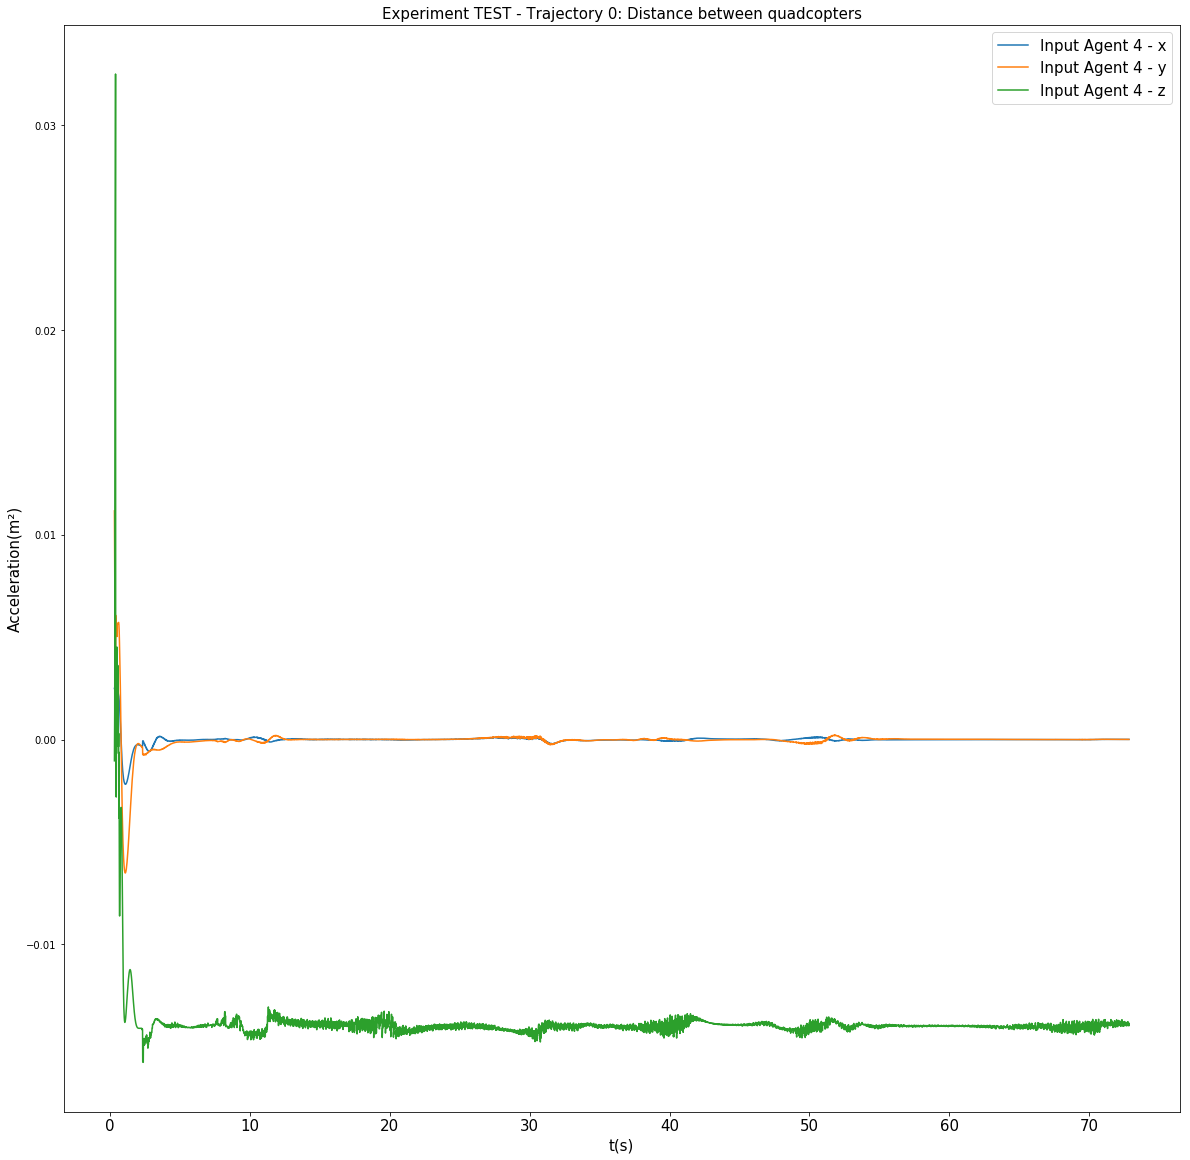

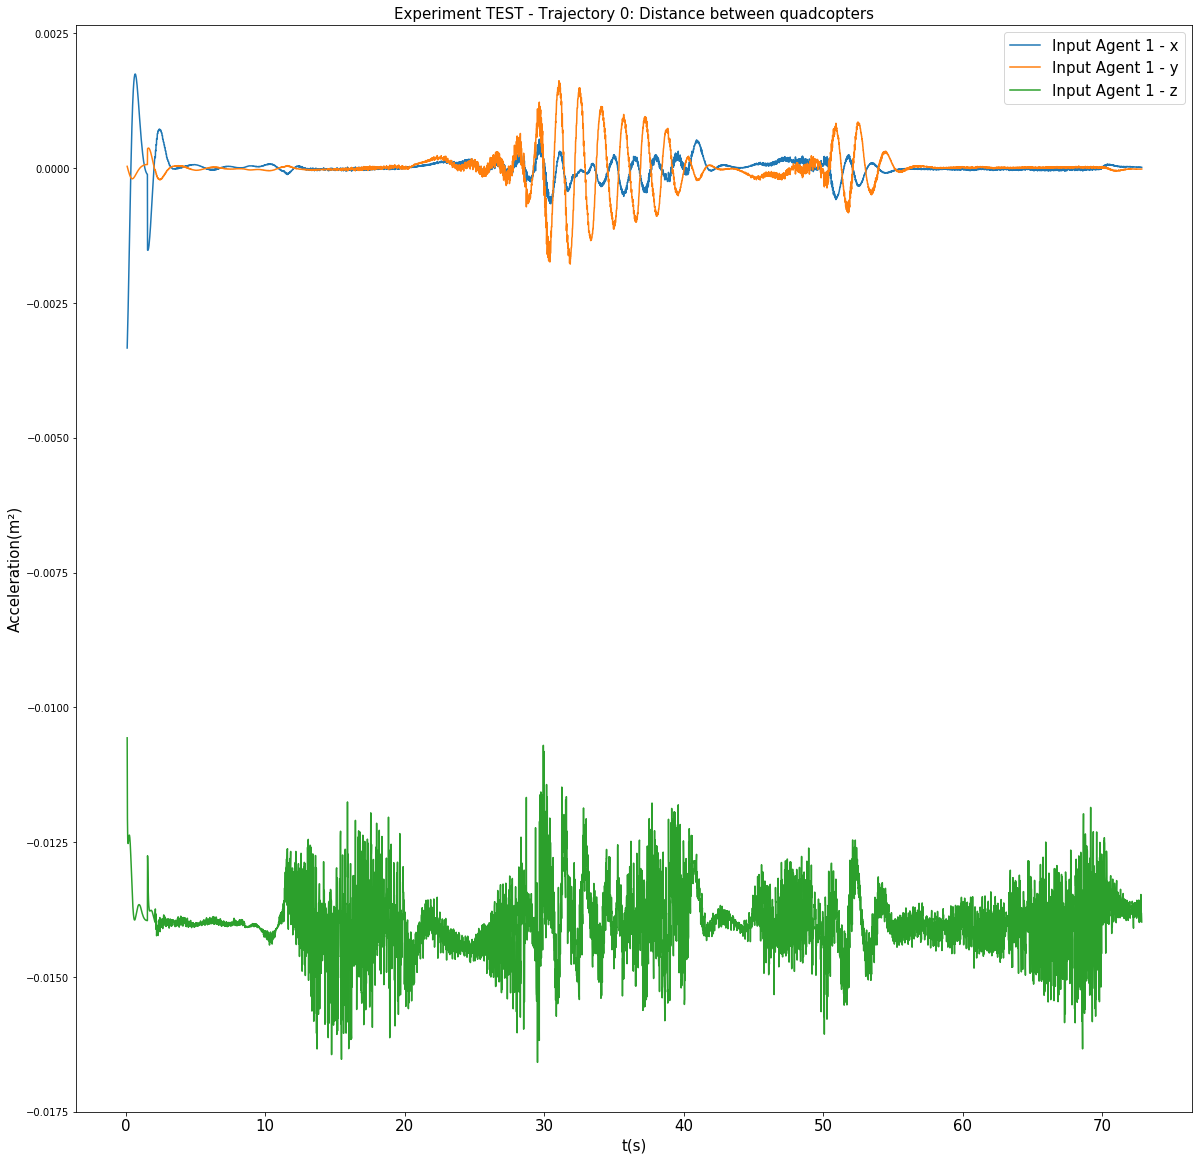

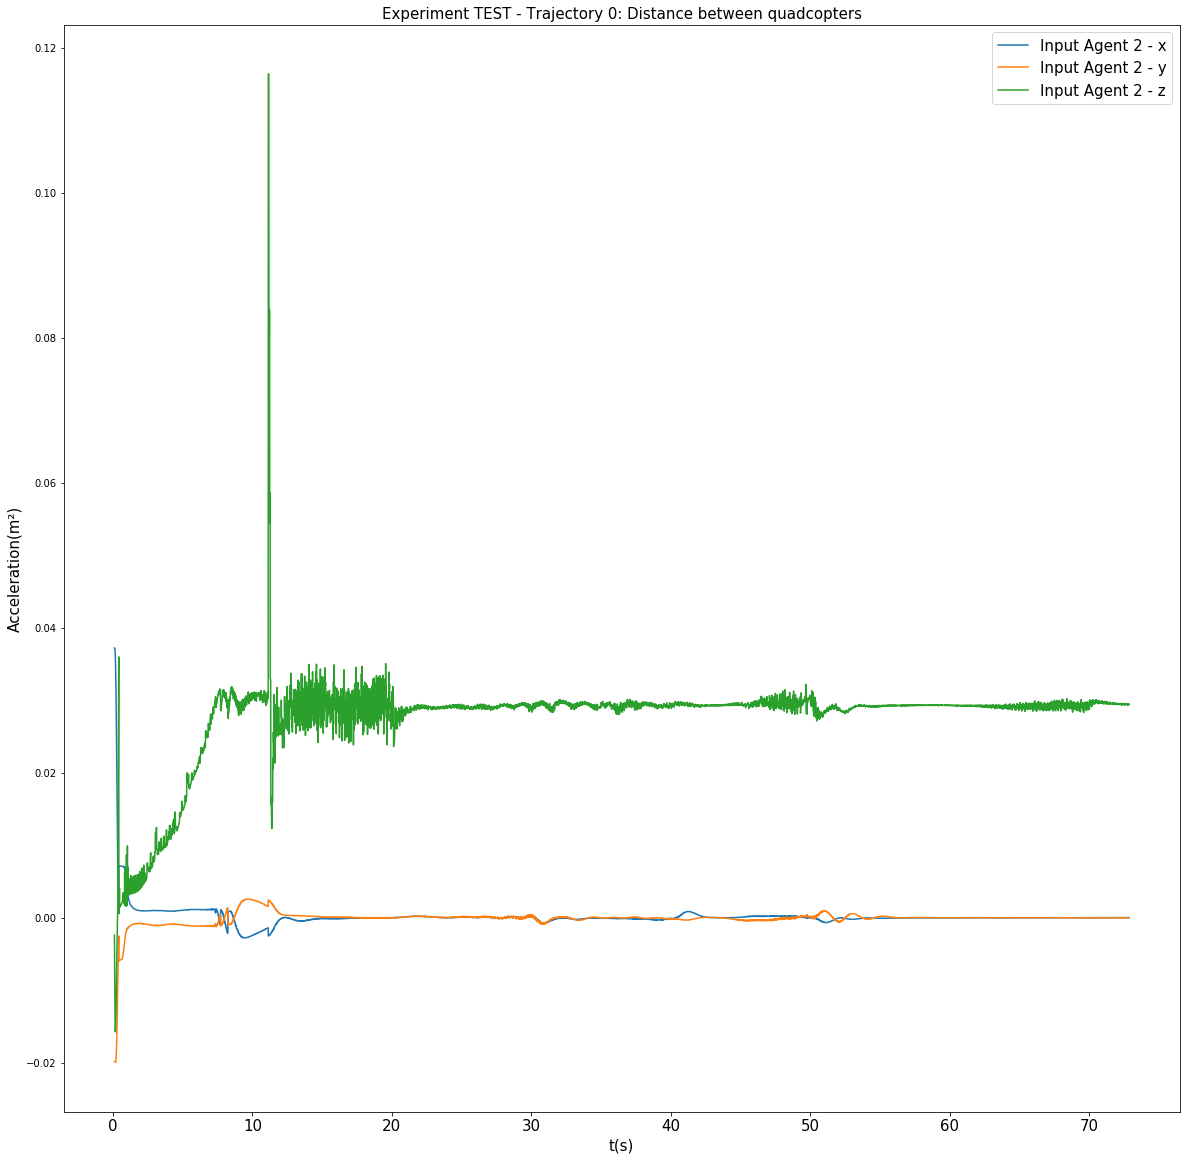

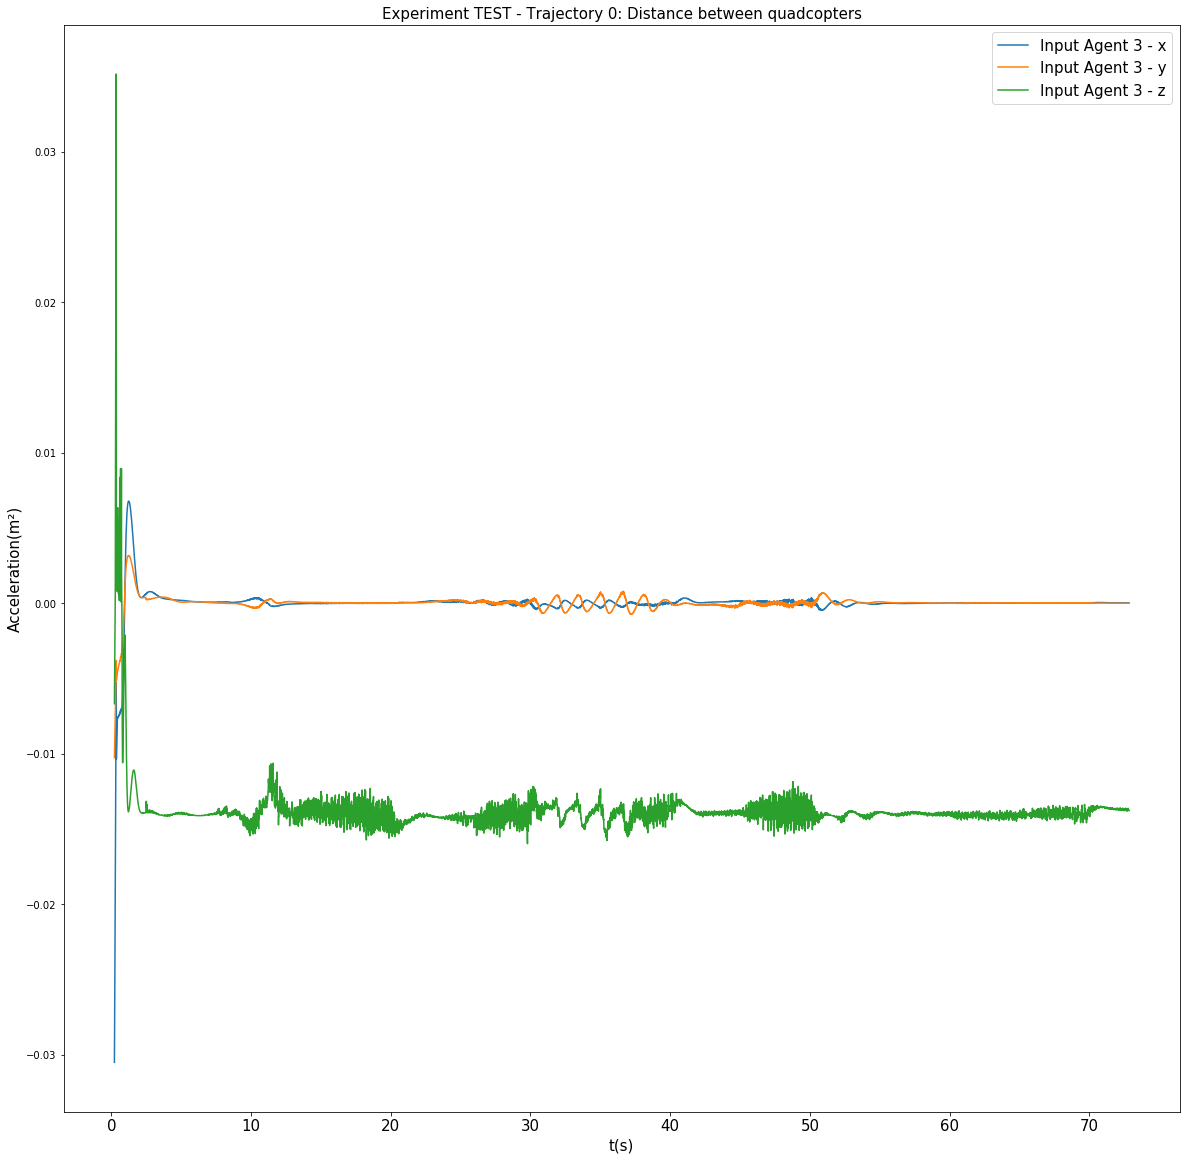

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(111)

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 0], label = "Input Agent " + drone.split("_")[1] + " - x")

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 1], label = "Input Agent " + drone.split("_")[1] + " - y")

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 2], label = "Input Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/3axis_forces_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/3axis_forces_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()

In [ ]:
import matplotlib.pyplot as plt

for experiment in data.keys():
    for drone in forcesBetas[experiment].keys():
        fig = plt.figure(figsize=(20, 20))

        ax1 = plt.subplot(311)

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 0], label = "Input Agent " + drone.split("_")[1] + " - x")
        
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
    
        ax2 = plt.subplot(312)

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 1], label = "Input Agent " + drone.split("_")[1] + " - y")
       
        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        
        ax3 = plt.subplot(313)

        plt.plot( data[experiment]["forces_" + drone]["time"], forcesBetas[experiment][drone]["force"][:, 2], label = "Input Agent " + drone.split("_")[1] + " - z")

        plt.title("Experiment " + experiment + " - Trajectory " + data[experiment]["trajectoryType"] + ": Distance between quadcopters", fontsize=15)
        plt.ylabel("Acceleration(m²)", fontsize=15)   
        plt.xlabel("t(s)", fontsize=15)   
        plt.setp(ax1.get_xticklabels(), fontsize=15)
        plt.legend(fontsize=15, loc='best')
        plt.savefig("./images/subplot_axis_forces_experiment_" + drone + ".png", bbox_inches='tight')
        plt.savefig("./images/subplot_axis_forces_experiment_" + drone + ".eps", bbox_inches='tight')
        plt.show()